In [1]:
import sys

import numpy as np
import pickle
import os
import pandas as pd

import time

import scanpy
import numpy as np

import torch
from torch import optim

import model_lord

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import anndata as ad

/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
skin_rnaPath='/data/xinyi/shareseq/skin_rna.h5ad'
skin_rna=scanpy.read(skin_rnaPath)

skin_atacPath='/data/xinyi/shareseq/skin_atac.h5ad'
skin_atac=scanpy.read(skin_atacPath)


scanpy.pp.filter_genes(skin_rna, min_cells=300)
scanpy.pp.filter_genes(skin_atac, min_cells=300)

scanpy.pp.filter_cells(skin_atac, min_genes=300)
scanpy.pp.filter_cells(skin_rna, min_genes=300)
skin_atac=skin_atac[skin_rna.obs.index]

scanpy.pp.filter_genes(skin_rna, min_cells=300)
scanpy.pp.filter_genes(skin_atac, min_cells=300)
scanpy.pp.filter_cells(skin_atac, min_genes=300)
scanpy.pp.filter_cells(skin_rna, min_genes=300)
skin_atac=skin_atac[skin_rna.obs.index]


atac=skin_atac.X.toarray()
rna=skin_rna.X.toarray()

atac_posweight=(atac.size-np.sum(atac))/np.sum(atac)
rna_posweight=(rna.size-np.sum(rna))/np.sum(rna)

/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [3]:
log_data=True
normalize='minmax'
hiddenSize=1024
sharedSize=50
dSpecificSize=20

In [4]:
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1

allIdx_all=np.arange(atac.shape[0])
np.random.shuffle(allIdx_all)
valIdx_all=allIdx_all[:int(pctVal*atac.shape[0])]
testIdx_all=allIdx_all[int(pctVal*atac.shape[0]):(int(pctVal*atac.shape[0])+int(pctTest*atac.shape[0]))]
trainIdx_all=allIdx_all[(int(pctVal*atac.shape[0])+int(pctTest*atac.shape[0])):]




In [5]:
#preprocess
if log_data:
    rna=np.log(rna+1/2)
    atac=np.log(atac+1/2)
if normalize=='zscore':
    scaler_rna = StandardScaler()
    scaler_rna.fit(rna[trainIdx_all])
    rna=scaler_rna.transform(rna)
    
    scaler_atac = StandardScaler()
    scaler_atac.fit(atac[trainIdx_all])
    atac=scaler_atac.transform(atac)
elif normalize=='minmax':
    rna=(rna-np.min(rna,axis=1,keepdims=True))/(np.max(rna,axis=1,keepdims=True)-np.min(rna,axis=1,keepdims=True))
    atac=(atac-np.min(atac,axis=1,keepdims=True))/(np.max(atac,axis=1,keepdims=True)-np.min(atac,axis=1,keepdims=True))

In [7]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

batchsize=512
saveFreq=100
epochs=10000
lr=0.0001
weight_decay=0
seed=3

dropout=0.01
XreconWeight=20
ridgeL=0.01

addNoise=True
actDecay=0.001

testSaveName='shareseq_lord'
name='randNoise_sharedRecon_bceWweight_bce_morefilter'
logsavepath=os.path.join('/data/xinyi/shareseq/results/log',testSaveName,name)
modelsavepath=os.path.join('/data/xinyi/shareseq/results/models',testSaveName,name)
plotsavepath=os.path.join('/data/xinyi/shareseq/results/plots',testSaveName,name)

loss_x_rna=torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(rna_posweight).cuda())
loss_x_atac=torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(atac_posweight).cuda())
loss_encode=torch.nn.MSELoss()

nFeatures_rna=rna.shape[1]
nFeatures_atac=atac.shape[1]

loadEpoch='4900'

train_nodes_idx=trainIdx_all
val_nodes_idx=valIdx_all




In [8]:
def train(epoch):
    t = time.time()
    model_rna.train()
    model_atac.train()
    
    loss_all=0
    loss_x_train_all_rna=0
    loss_x_train_all_atac=0
    loss_x_trainShared_all_rna=0
    loss_x_trainShared_all_atac=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        traintarget_rna=torch.tensor(rna[trainIdx]).cuda().float()
        traintarget_atac=torch.tensor(atac[trainIdx]).cuda().float()
        trainIdx=torch.tensor(trainIdx)
        trainInput_shared=latent_shared_dec(trainIdx).cuda().float()
        trainInput_rna=latent_rna_dec(trainIdx).cuda().float()
        trainInput_atac=latent_atac_dec(trainIdx).cuda().float()

        optimizer_rna.zero_grad()
        optimizer_atac.zero_grad()

        recon_rna_shared,recon_rna_d= model_rna(traintarget_rna)
        atac_recon_shared,atac_recon_d = model_atac(traintarget_atac)

        loss_x_train_rna=loss_encode(recon_rna_d,trainInput_rna)
        loss_x_trainShared_rna=loss_encode(recon_rna_shared,trainInput_shared)

        loss_x_train_atac=loss_encode(atac_recon_d,trainInput_atac)
        loss_x_trainShared_atac=loss_encode(atac_recon_shared,trainInput_shared)
        loss=loss_x_train_rna+loss_x_train_atac+loss_x_trainShared_rna+loss_x_trainShared_atac
        
            
        loss_x_trainShared_all_atac+=loss_x_trainShared_atac.item()
        loss_x_trainShared_all_rna+=loss_x_trainShared_rna.item()
        loss_x_train_all_atac+=loss_x_train_atac.item()
        loss_x_train_all_rna+=loss_x_train_rna.item()
        loss_all+=loss.item()
        
            
        loss.backward()
        optimizer_rna.step()
        optimizer_atac.step()


    loss_x_trainShared_all_atac=loss_x_trainShared_all_atac/ntrainBatches
    loss_x_trainShared_all_rna=loss_x_trainShared_all_rna/ntrainBatches
    loss_x_train_all_atac=loss_x_train_all_atac/ntrainBatches
    loss_x_train_all_rna=loss_x_train_all_rna/ntrainBatches
    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        model_rna.eval()
        model_atac.eval()
        loss_x_val_all_rna=0
        loss_x_val_all_atac=0
        loss_x_valShared_all_rna=0
        loss_x_valShared_all_atac=0
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            valtarget_rna=torch.tensor(rna[valIdx]).cuda().float()
            valtarget_atac=torch.tensor(atac[valIdx]).cuda().float()
            valIdx=torch.tensor(valIdx)
            valInput_shared=latent_shared_dec(valIdx).cuda().float()
            valInput_rna=latent_rna_dec(valIdx).cuda().float()
            valInput_atac=latent_atac_dec(valIdx).cuda().float()

            recon_rna_shared,recon_rna_d= model_rna(valtarget_rna)
            atac_recon_shared,atac_recon_d = model_atac(valtarget_atac)

            recon_rna= model_rna_dec(torch.cat((recon_rna_shared,recon_rna_d),dim=1))
            atac_recon = model_atac_dec(torch.cat((atac_recon_shared,atac_recon_d),dim=1))
            recon_rna_sharedRecon= model_rna_shared_dec(recon_rna_shared)
            atac_recon_sharedRecon = model_atac_shared_dec(atac_recon_shared)



            loss_x_valShared_rna=loss_x_rna(recon_rna_sharedRecon, valtarget_rna)
            loss_x_valShared_atac=loss_x_atac(atac_recon_sharedRecon, valtarget_atac)
            loss_x_val_rna=loss_x_rna(recon_rna, valtarget_rna)
            loss_x_val_atac=loss_x_atac(atac_recon, valtarget_atac)

            loss=loss_x_val_rna+loss_x_val_atac+loss_x_valShared_rna+loss_x_valShared_atac

            
            loss_x_valShared_all_rna+=loss_x_valShared_rna.item()
            loss_x_valShared_all_atac+=loss_x_valShared_atac.item()
            loss_x_val_all_rna+=loss_x_val_rna.item()
            loss_x_val_all_atac+=loss_x_val_atac.item()
            loss_val_all+=loss.item()

        loss_x_valShared_all_rna=loss_x_valShared_all_rna/nvalBatches
        loss_x_valShared_all_atac=loss_x_valShared_all_atac/nvalBatches
        loss_x_val_all_rna=loss_x_val_all_rna/nvalBatches
        loss_x_val_all_atac=loss_x_val_all_atac/nvalBatches
        loss_val_all=loss_val_all/nvalBatches
    
    print(' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_x_train_rna: {:.4f}'.format(loss_x_train_all_rna),
          'loss_x_train_atac: {:.4f}'.format(loss_x_train_all_atac),
          'loss_xShared_train_rna: {:.4f}'.format(loss_x_trainShared_all_rna),
          'loss_xShared_train_atac: {:.4f}'.format(loss_x_trainShared_all_atac),
          'loss_val: {:.4f}'.format(loss_val_all),
          'loss_x_val_rna: {:.4f}'.format(loss_x_val_all_rna),
          'loss_x_val_atac: {:.4f}'.format(loss_x_val_all_atac),
          'loss_x_valShared_rna: {:.4f}'.format(loss_x_valShared_all_rna),
          'loss_x_valShared_atac: {:.4f}'.format(loss_x_valShared_all_atac),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_x_train_all_rna,loss_x_train_all_atac,loss_x_trainShared_all_rna,loss_x_trainShared_all_atac,loss_val_all,loss_x_val_all_rna,loss_x_val_all_atac,loss_x_valShared_all_rna,loss_x_valShared_all_atac






In [9]:

model_rna_dec = model_lord.fc_decode_l4(nFeatures_rna,sharedSize+dSpecificSize,hiddenSize, dropout)
model_atac_dec = model_lord.fc_decode_l4(nFeatures_atac, sharedSize+dSpecificSize,hiddenSize, dropout)

model_rna_shared_dec = model_lord.fc_decode_l4(nFeatures_rna,sharedSize,hiddenSize, dropout)
model_atac_shared_dec = model_lord.fc_decode_l4(nFeatures_atac, sharedSize,hiddenSize, dropout)



model_rna_dec.cuda()
model_atac_dec.cuda()
model_rna_shared_dec.cuda()
model_atac_shared_dec.cuda()



latent_shared_dec=torch.nn.Embedding(rna.shape[0],sharedSize)
latent_rna_dec=torch.nn.Embedding(rna.shape[0],dSpecificSize)
latent_atac_dec=torch.nn.Embedding(rna.shape[0],dSpecificSize)
with open(os.path.join(modelsavepath,'latentRNA_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch)), 'rb') as output:
    latent_rna_dec.weight=pickle.load(output)
with open(os.path.join(modelsavepath,'latentShared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch)), 'rb') as output:
    latent_shared_dec.weight=pickle.load( output)
with open(os.path.join(modelsavepath,'latentATAC_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch)), 'rb') as output:
    latent_atac_dec.weight=pickle.load(output)
latent_rna_dec.weight.requires_grad=False
latent_shared_dec.weight.requires_grad=False
latent_atac_dec.weight.requires_grad=False

model_rna_dec.load_state_dict(torch.load(os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch)+'_rna.pt')))
model_atac_dec.load_state_dict(torch.load(os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch)+'_atac.pt')))
model_rna_dec.eval()
model_atac_dec.eval()
model_rna_shared_dec.load_state_dict(torch.load(os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch)+'_rnaShared.pt')))
model_atac_shared_dec.load_state_dict(torch.load(os.path.join(modelsavepath,str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_ep'+str(loadEpoch)+'_atacShared.pt')))
model_rna_shared_dec.eval()
model_atac_shared_dec.eval()


np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True

model_rna= model_lord.fc_encode_l4(nFeatures_rna,hiddenSize,sharedSize,dSpecificSize,sharedSize,dSpecificSize, dropout)
model_atac= model_lord.fc_encode_l4(nFeatures_atac,hiddenSize,sharedSize,dSpecificSize,sharedSize,dSpecificSize, dropout)
model_rna.cuda()
model_atac.cuda()

optimizer_rna = torch.optim.Adam(model_rna.parameters(), lr=lr, weight_decay=weight_decay)
optimizer_atac = torch.optim.Adam(model_atac.parameters(), lr=lr, weight_decay=weight_decay)

train_loss=[np.inf]*(epochs)
val_loss=[np.inf]*(epochs)

train_loss_rna=[np.inf]*(epochs)
val_loss_rna=[np.inf]*(epochs)
train_loss_rna_shared=[np.inf]*(epochs)
val_loss_rna_shared=[np.inf]*(epochs)

train_loss_atac=[np.inf]*(epochs)
train_loss_atac_shared=[np.inf]*(epochs)
val_loss_atac=[np.inf]*(epochs)
val_loss_atac_shared=[np.inf]*(epochs)

t_ep=time.time()

for ep in range(epochs):

    train_loss[ep],train_loss_rna[ep],train_loss_atac[ep],train_loss_rna_shared[ep],train_loss_atac_shared[ep],val_loss[ep],val_loss_rna[ep],val_loss_atac[ep],val_loss_rna_shared[ep],val_loss_atac_shared[ep]=train(ep)


    if ep%saveFreq == 0 and ep != 0:
        torch.save(model_rna.cpu().state_dict(), os.path.join(modelsavepath,'encode_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_'+str(loadEpoch)+'_ep'+str(ep)+'_rna.pt'))
        torch.save(model_atac.cpu().state_dict(), os.path.join(modelsavepath,'encode_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_'+str(loadEpoch)+'_ep'+str(ep)+'_atac.pt'))


    model_rna.cuda()
    model_atac.cuda()
    torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))



 Epoch: 0000 loss_train: 149.5082 loss_x_train_rna: 27.9947 loss_x_train_atac: 33.4252 loss_xShared_train_rna: 44.2073 loss_xShared_train_atac: 43.8810 loss_val: 2.2337 loss_x_val_rna: 0.2766 loss_x_val_atac: 0.8407 loss_x_valShared_rna: 0.2761 loss_x_valShared_atac: 0.8402 time: 6.7083s
 Epoch: 0001 loss_train: 144.6358 loss_x_train_rna: 27.1753 loss_x_train_atac: 31.5964 loss_xShared_train_rna: 43.3931 loss_xShared_train_atac: 42.4711 loss_val: 2.2340 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8414 loss_x_valShared_rna: 0.2760 loss_x_valShared_atac: 0.8402 time: 6.0974s
 Epoch: 0002 loss_train: 141.4041 loss_x_train_rna: 26.4462 loss_x_train_atac: 30.7752 loss_xShared_train_rna: 42.7460 loss_xShared_train_atac: 41.4367 loss_val: 2.2344 loss_x_val_rna: 0.2764 loss_x_val_atac: 0.8417 loss_x_valShared_rna: 0.2759 loss_x_valShared_atac: 0.8403 time: 6.0489s
 Epoch: 0003 loss_train: 139.1468 loss_x_train_rna: 25.9279 loss_x_train_atac: 30.3443 loss_xShared_train_rna: 42.1092 loss_xShared_t

 Epoch: 0029 loss_train: 114.0451 loss_x_train_rna: 21.4491 loss_x_train_atac: 25.9055 loss_xShared_train_rna: 33.4067 loss_xShared_train_atac: 33.2838 loss_val: 2.2113 loss_x_val_rna: 0.2741 loss_x_val_atac: 0.8336 loss_x_valShared_rna: 0.2735 loss_x_valShared_atac: 0.8301 time: 6.0946s
 Epoch: 0030 loss_train: 113.1694 loss_x_train_rna: 21.2996 loss_x_train_atac: 25.7414 loss_xShared_train_rna: 33.1198 loss_xShared_train_atac: 33.0087 loss_val: 2.2138 loss_x_val_rna: 0.2744 loss_x_val_atac: 0.8343 loss_x_valShared_rna: 0.2740 loss_x_valShared_atac: 0.8311 time: 6.0859s
 Epoch: 0031 loss_train: 112.3378 loss_x_train_rna: 21.1567 loss_x_train_atac: 25.5857 loss_xShared_train_rna: 32.8447 loss_xShared_train_atac: 32.7507 loss_val: 2.2132 loss_x_val_rna: 0.2745 loss_x_val_atac: 0.8339 loss_x_valShared_rna: 0.2742 loss_x_valShared_atac: 0.8307 time: 6.0256s
 Epoch: 0032 loss_train: 111.5169 loss_x_train_rna: 21.0152 loss_x_train_atac: 25.4418 loss_xShared_train_rna: 32.5638 loss_xShared_t

 Epoch: 0058 loss_train: 90.2690 loss_x_train_rna: 17.2694 loss_x_train_atac: 21.3301 loss_xShared_train_rna: 25.6646 loss_xShared_train_atac: 26.0048 loss_val: 2.1873 loss_x_val_rna: 0.2709 loss_x_val_atac: 0.8253 loss_x_valShared_rna: 0.2713 loss_x_valShared_atac: 0.8198 time: 6.0750s
 Epoch: 0059 loss_train: 89.5029 loss_x_train_rna: 17.1274 loss_x_train_atac: 21.1775 loss_xShared_train_rna: 25.4147 loss_xShared_train_atac: 25.7831 loss_val: 2.1824 loss_x_val_rna: 0.2705 loss_x_val_atac: 0.8232 loss_x_valShared_rna: 0.2707 loss_x_valShared_atac: 0.8180 time: 6.0830s
 Epoch: 0060 loss_train: 88.7618 loss_x_train_rna: 16.9970 loss_x_train_atac: 21.0341 loss_xShared_train_rna: 25.1717 loss_xShared_train_atac: 25.5590 loss_val: 2.1846 loss_x_val_rna: 0.2707 loss_x_val_atac: 0.8235 loss_x_valShared_rna: 0.2709 loss_x_valShared_atac: 0.8195 time: 6.1756s
 Epoch: 0061 loss_train: 88.0264 loss_x_train_rna: 16.8625 loss_x_train_atac: 20.8956 loss_xShared_train_rna: 24.9297 loss_xShared_train

 Epoch: 0087 loss_train: 70.2850 loss_x_train_rna: 13.6739 loss_x_train_atac: 17.2778 loss_xShared_train_rna: 19.2634 loss_xShared_train_atac: 20.0699 loss_val: 2.1657 loss_x_val_rna: 0.2673 loss_x_val_atac: 0.8179 loss_x_valShared_rna: 0.2680 loss_x_valShared_atac: 0.8125 time: 6.1511s
 Epoch: 0088 loss_train: 69.6631 loss_x_train_rna: 13.5459 loss_x_train_atac: 17.1263 loss_xShared_train_rna: 19.0840 loss_xShared_train_atac: 19.9069 loss_val: 2.1620 loss_x_val_rna: 0.2668 loss_x_val_atac: 0.8166 loss_x_valShared_rna: 0.2672 loss_x_valShared_atac: 0.8115 time: 6.1372s
 Epoch: 0089 loss_train: 69.0583 loss_x_train_rna: 13.4261 loss_x_train_atac: 17.0097 loss_xShared_train_rna: 18.8925 loss_xShared_train_atac: 19.7301 loss_val: 2.1637 loss_x_val_rna: 0.2669 loss_x_val_atac: 0.8168 loss_x_valShared_rna: 0.2673 loss_x_valShared_atac: 0.8126 time: 6.1273s
 Epoch: 0090 loss_train: 68.4694 loss_x_train_rna: 13.3229 loss_x_train_atac: 16.8838 loss_xShared_train_rna: 18.7136 loss_xShared_train

 Epoch: 0116 loss_train: 54.3644 loss_x_train_rna: 10.7075 loss_x_train_atac: 13.7897 loss_xShared_train_rna: 14.4737 loss_xShared_train_atac: 15.3935 loss_val: 2.1402 loss_x_val_rna: 0.2641 loss_x_val_atac: 0.8086 loss_x_valShared_rna: 0.2648 loss_x_valShared_atac: 0.8027 time: 6.1109s
 Epoch: 0117 loss_train: 53.8930 loss_x_train_rna: 10.6124 loss_x_train_atac: 13.6760 loss_xShared_train_rna: 14.3365 loss_xShared_train_atac: 15.2681 loss_val: 2.1437 loss_x_val_rna: 0.2645 loss_x_val_atac: 0.8093 loss_x_valShared_rna: 0.2650 loss_x_valShared_atac: 0.8050 time: 6.5485s
 Epoch: 0118 loss_train: 53.4685 loss_x_train_rna: 10.5391 loss_x_train_atac: 13.5694 loss_xShared_train_rna: 14.2148 loss_xShared_train_atac: 15.1453 loss_val: 2.1423 loss_x_val_rna: 0.2646 loss_x_val_atac: 0.8080 loss_x_valShared_rna: 0.2651 loss_x_valShared_atac: 0.8046 time: 6.1567s
 Epoch: 0119 loss_train: 53.0042 loss_x_train_rna: 10.4582 loss_x_train_atac: 13.4678 loss_xShared_train_rna: 14.0550 loss_xShared_train

 Epoch: 0145 loss_train: 42.6799 loss_x_train_rna: 8.4844 loss_x_train_atac: 10.9500 loss_xShared_train_rna: 11.1766 loss_xShared_train_atac: 12.0690 loss_val: 2.1333 loss_x_val_rna: 0.2614 loss_x_val_atac: 0.8064 loss_x_valShared_rna: 0.2630 loss_x_valShared_atac: 0.8025 time: 5.7133s
 Epoch: 0146 loss_train: 42.2697 loss_x_train_rna: 8.3927 loss_x_train_atac: 10.8584 loss_xShared_train_rna: 11.0748 loss_xShared_train_atac: 11.9437 loss_val: 2.1357 loss_x_val_rna: 0.2617 loss_x_val_atac: 0.8072 loss_x_valShared_rna: 0.2628 loss_x_valShared_atac: 0.8040 time: 5.6655s
 Epoch: 0147 loss_train: 41.9498 loss_x_train_rna: 8.3463 loss_x_train_atac: 10.7654 loss_xShared_train_rna: 10.9824 loss_xShared_train_atac: 11.8557 loss_val: 2.1377 loss_x_val_rna: 0.2615 loss_x_val_atac: 0.8086 loss_x_valShared_rna: 0.2625 loss_x_valShared_atac: 0.8051 time: 5.6900s
 Epoch: 0148 loss_train: 41.5913 loss_x_train_rna: 8.2705 loss_x_train_atac: 10.6794 loss_xShared_train_rna: 10.8958 loss_xShared_train_ata

 Epoch: 0174 loss_train: 34.6171 loss_x_train_rna: 6.8510 loss_x_train_atac: 8.8737 loss_xShared_train_rna: 9.0941 loss_xShared_train_atac: 9.7982 loss_val: 2.1235 loss_x_val_rna: 0.2608 loss_x_val_atac: 0.8009 loss_x_valShared_rna: 0.2629 loss_x_valShared_atac: 0.7989 time: 5.8731s
 Epoch: 0175 loss_train: 34.3671 loss_x_train_rna: 6.8115 loss_x_train_atac: 8.8094 loss_xShared_train_rna: 9.0311 loss_xShared_train_atac: 9.7151 loss_val: 2.1278 loss_x_val_rna: 0.2609 loss_x_val_atac: 0.8027 loss_x_valShared_rna: 0.2631 loss_x_valShared_atac: 0.8011 time: 5.6853s
 Epoch: 0176 loss_train: 34.1405 loss_x_train_rna: 6.7627 loss_x_train_atac: 8.7594 loss_xShared_train_rna: 8.9535 loss_xShared_train_atac: 9.6649 loss_val: 2.1251 loss_x_val_rna: 0.2608 loss_x_val_atac: 0.8018 loss_x_valShared_rna: 0.2628 loss_x_valShared_atac: 0.7997 time: 5.6946s
 Epoch: 0177 loss_train: 33.9892 loss_x_train_rna: 6.7248 loss_x_train_atac: 8.7239 loss_xShared_train_rna: 8.9109 loss_xShared_train_atac: 9.6296 l

 Epoch: 0203 loss_train: 29.4193 loss_x_train_rna: 5.7850 loss_x_train_atac: 7.4923 loss_xShared_train_rna: 7.8056 loss_xShared_train_atac: 8.3364 loss_val: 2.1252 loss_x_val_rna: 0.2609 loss_x_val_atac: 0.8009 loss_x_valShared_rna: 0.2640 loss_x_valShared_atac: 0.7993 time: 5.6326s
 Epoch: 0204 loss_train: 29.3060 loss_x_train_rna: 5.7493 loss_x_train_atac: 7.4314 loss_xShared_train_rna: 7.8215 loss_xShared_train_atac: 8.3038 loss_val: 2.1216 loss_x_val_rna: 0.2607 loss_x_val_atac: 0.7998 loss_x_valShared_rna: 0.2632 loss_x_valShared_atac: 0.7980 time: 5.6832s
 Epoch: 0205 loss_train: 29.1327 loss_x_train_rna: 5.7276 loss_x_train_atac: 7.3924 loss_xShared_train_rna: 7.7414 loss_xShared_train_atac: 8.2712 loss_val: 2.1215 loss_x_val_rna: 0.2607 loss_x_val_atac: 0.8002 loss_x_valShared_rna: 0.2630 loss_x_valShared_atac: 0.7977 time: 5.6497s
 Epoch: 0206 loss_train: 29.0160 loss_x_train_rna: 5.7218 loss_x_train_atac: 7.3498 loss_xShared_train_rna: 7.7179 loss_xShared_train_atac: 8.2265 l

 Epoch: 0232 loss_train: 26.0621 loss_x_train_rna: 5.1798 loss_x_train_atac: 6.4656 loss_xShared_train_rna: 7.0650 loss_xShared_train_atac: 7.3517 loss_val: 2.1241 loss_x_val_rna: 0.2605 loss_x_val_atac: 0.8005 loss_x_valShared_rna: 0.2626 loss_x_valShared_atac: 0.8004 time: 5.6715s
 Epoch: 0233 loss_train: 25.9634 loss_x_train_rna: 5.1640 loss_x_train_atac: 6.4526 loss_xShared_train_rna: 7.0073 loss_xShared_train_atac: 7.3396 loss_val: 2.1284 loss_x_val_rna: 0.2607 loss_x_val_atac: 0.8010 loss_x_valShared_rna: 0.2637 loss_x_valShared_atac: 0.8030 time: 5.7444s
 Epoch: 0234 loss_train: 25.9236 loss_x_train_rna: 5.1567 loss_x_train_atac: 6.4651 loss_xShared_train_rna: 7.0073 loss_xShared_train_atac: 7.2945 loss_val: 2.1326 loss_x_val_rna: 0.2606 loss_x_val_atac: 0.8031 loss_x_valShared_rna: 0.2638 loss_x_valShared_atac: 0.8050 time: 5.6613s
 Epoch: 0235 loss_train: 25.7929 loss_x_train_rna: 5.1361 loss_x_train_atac: 6.4064 loss_xShared_train_rna: 6.9822 loss_xShared_train_atac: 7.2683 l

 Epoch: 0261 loss_train: 23.6660 loss_x_train_rna: 4.7710 loss_x_train_atac: 5.8228 loss_xShared_train_rna: 6.3764 loss_xShared_train_atac: 6.6959 loss_val: 2.1274 loss_x_val_rna: 0.2605 loss_x_val_atac: 0.8021 loss_x_valShared_rna: 0.2629 loss_x_valShared_atac: 0.8019 time: 5.7105s
 Epoch: 0262 loss_train: 23.5812 loss_x_train_rna: 4.7600 loss_x_train_atac: 5.8565 loss_xShared_train_rna: 6.3411 loss_xShared_train_atac: 6.6235 loss_val: 2.1253 loss_x_val_rna: 0.2605 loss_x_val_atac: 0.8008 loss_x_valShared_rna: 0.2629 loss_x_valShared_atac: 0.8011 time: 5.6623s
 Epoch: 0263 loss_train: 23.4982 loss_x_train_rna: 4.7535 loss_x_train_atac: 5.7961 loss_xShared_train_rna: 6.3303 loss_xShared_train_atac: 6.6184 loss_val: 2.1293 loss_x_val_rna: 0.2606 loss_x_val_atac: 0.8024 loss_x_valShared_rna: 0.2630 loss_x_valShared_atac: 0.8033 time: 5.6434s
 Epoch: 0264 loss_train: 23.4633 loss_x_train_rna: 4.7300 loss_x_train_atac: 5.7845 loss_xShared_train_rna: 6.3357 loss_xShared_train_atac: 6.6131 l

 Epoch: 0290 loss_train: 21.8732 loss_x_train_rna: 4.4729 loss_x_train_atac: 5.3404 loss_xShared_train_rna: 5.9719 loss_xShared_train_atac: 6.0881 loss_val: 2.1492 loss_x_val_rna: 0.2604 loss_x_val_atac: 0.8137 loss_x_valShared_rna: 0.2623 loss_x_valShared_atac: 0.8129 time: 5.6645s
 Epoch: 0291 loss_train: 21.8499 loss_x_train_rna: 4.4384 loss_x_train_atac: 5.3019 loss_xShared_train_rna: 5.9860 loss_xShared_train_atac: 6.1236 loss_val: 2.1523 loss_x_val_rna: 0.2603 loss_x_val_atac: 0.8144 loss_x_valShared_rna: 0.2625 loss_x_valShared_atac: 0.8151 time: 5.6684s
 Epoch: 0292 loss_train: 21.7690 loss_x_train_rna: 4.4653 loss_x_train_atac: 5.3212 loss_xShared_train_rna: 5.9258 loss_xShared_train_atac: 6.0566 loss_val: 2.1479 loss_x_val_rna: 0.2602 loss_x_val_atac: 0.8124 loss_x_valShared_rna: 0.2625 loss_x_valShared_atac: 0.8129 time: 5.6606s
 Epoch: 0293 loss_train: 21.6712 loss_x_train_rna: 4.4345 loss_x_train_atac: 5.2883 loss_xShared_train_rna: 5.8978 loss_xShared_train_atac: 6.0507 l

 Epoch: 0319 loss_train: 20.5680 loss_x_train_rna: 4.2458 loss_x_train_atac: 5.0249 loss_xShared_train_rna: 5.5972 loss_xShared_train_atac: 5.7000 loss_val: 2.1261 loss_x_val_rna: 0.2607 loss_x_val_atac: 0.8018 loss_x_valShared_rna: 0.2627 loss_x_valShared_atac: 0.8008 time: 5.6931s
 Epoch: 0320 loss_train: 20.5002 loss_x_train_rna: 4.2441 loss_x_train_atac: 5.0035 loss_xShared_train_rna: 5.5545 loss_xShared_train_atac: 5.6981 loss_val: 2.1347 loss_x_val_rna: 0.2606 loss_x_val_atac: 0.8063 loss_x_valShared_rna: 0.2629 loss_x_valShared_atac: 0.8050 time: 5.7190s
 Epoch: 0321 loss_train: 20.3978 loss_x_train_rna: 4.2307 loss_x_train_atac: 4.9490 loss_xShared_train_rna: 5.5666 loss_xShared_train_atac: 5.6515 loss_val: 2.1503 loss_x_val_rna: 0.2607 loss_x_val_atac: 0.8143 loss_x_valShared_rna: 0.2638 loss_x_valShared_atac: 0.8116 time: 5.7417s
 Epoch: 0322 loss_train: 20.3396 loss_x_train_rna: 4.2182 loss_x_train_atac: 4.9560 loss_xShared_train_rna: 5.5392 loss_xShared_train_atac: 5.6262 l

 Epoch: 0348 loss_train: 19.2442 loss_x_train_rna: 4.0294 loss_x_train_atac: 4.6193 loss_xShared_train_rna: 5.2425 loss_xShared_train_atac: 5.3530 loss_val: 2.1412 loss_x_val_rna: 0.2607 loss_x_val_atac: 0.8092 loss_x_valShared_rna: 0.2637 loss_x_valShared_atac: 0.8076 time: 5.7012s
 Epoch: 0349 loss_train: 19.1378 loss_x_train_rna: 4.0097 loss_x_train_atac: 4.6297 loss_xShared_train_rna: 5.1803 loss_xShared_train_atac: 5.3181 loss_val: 2.1437 loss_x_val_rna: 0.2608 loss_x_val_atac: 0.8104 loss_x_valShared_rna: 0.2641 loss_x_valShared_atac: 0.8085 time: 5.6588s
 Epoch: 0350 loss_train: 19.1406 loss_x_train_rna: 4.0056 loss_x_train_atac: 4.6631 loss_xShared_train_rna: 5.1659 loss_xShared_train_atac: 5.3060 loss_val: 2.1476 loss_x_val_rna: 0.2609 loss_x_val_atac: 0.8121 loss_x_valShared_rna: 0.2641 loss_x_valShared_atac: 0.8106 time: 5.6717s
 Epoch: 0351 loss_train: 19.1377 loss_x_train_rna: 4.0009 loss_x_train_atac: 4.6462 loss_xShared_train_rna: 5.1964 loss_xShared_train_atac: 5.2942 l

 Epoch: 0377 loss_train: 18.2084 loss_x_train_rna: 3.8954 loss_x_train_atac: 4.3830 loss_xShared_train_rna: 4.9603 loss_xShared_train_atac: 4.9697 loss_val: 2.1347 loss_x_val_rna: 0.2617 loss_x_val_atac: 0.8041 loss_x_valShared_rna: 0.2651 loss_x_valShared_atac: 0.8038 time: 5.7704s
 Epoch: 0378 loss_train: 18.1359 loss_x_train_rna: 3.8654 loss_x_train_atac: 4.3605 loss_xShared_train_rna: 4.9841 loss_xShared_train_atac: 4.9259 loss_val: 2.1323 loss_x_val_rna: 0.2616 loss_x_val_atac: 0.8030 loss_x_valShared_rna: 0.2647 loss_x_valShared_atac: 0.8029 time: 5.7684s
 Epoch: 0379 loss_train: 18.0150 loss_x_train_rna: 3.8410 loss_x_train_atac: 4.3140 loss_xShared_train_rna: 4.9335 loss_xShared_train_atac: 4.9265 loss_val: 2.1339 loss_x_val_rna: 0.2613 loss_x_val_atac: 0.8041 loss_x_valShared_rna: 0.2639 loss_x_valShared_atac: 0.8045 time: 5.7006s
 Epoch: 0380 loss_train: 18.0480 loss_x_train_rna: 3.8201 loss_x_train_atac: 4.3496 loss_xShared_train_rna: 4.9214 loss_xShared_train_atac: 4.9569 l

 Epoch: 0406 loss_train: 17.3671 loss_x_train_rna: 3.7637 loss_x_train_atac: 4.1627 loss_xShared_train_rna: 4.7308 loss_xShared_train_atac: 4.7098 loss_val: 2.1365 loss_x_val_rna: 0.2602 loss_x_val_atac: 0.8073 loss_x_valShared_rna: 0.2627 loss_x_valShared_atac: 0.8063 time: 5.8050s
 Epoch: 0407 loss_train: 17.2448 loss_x_train_rna: 3.6803 loss_x_train_atac: 4.1545 loss_xShared_train_rna: 4.6855 loss_xShared_train_atac: 4.7245 loss_val: 2.1388 loss_x_val_rna: 0.2604 loss_x_val_atac: 0.8080 loss_x_valShared_rna: 0.2629 loss_x_valShared_atac: 0.8075 time: 5.7617s
 Epoch: 0408 loss_train: 17.1282 loss_x_train_rna: 3.7313 loss_x_train_atac: 4.1232 loss_xShared_train_rna: 4.6322 loss_xShared_train_atac: 4.6415 loss_val: 2.1387 loss_x_val_rna: 0.2604 loss_x_val_atac: 0.8077 loss_x_valShared_rna: 0.2630 loss_x_valShared_atac: 0.8076 time: 5.7308s
 Epoch: 0409 loss_train: 17.1428 loss_x_train_rna: 3.6565 loss_x_train_atac: 4.1248 loss_xShared_train_rna: 4.6621 loss_xShared_train_atac: 4.6995 l

 Epoch: 0435 loss_train: 16.5357 loss_x_train_rna: 3.5976 loss_x_train_atac: 3.9899 loss_xShared_train_rna: 4.4680 loss_xShared_train_atac: 4.4801 loss_val: 2.1433 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8112 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.8104 time: 5.7870s
 Epoch: 0436 loss_train: 16.4394 loss_x_train_rna: 3.5400 loss_x_train_atac: 3.9853 loss_xShared_train_rna: 4.4655 loss_xShared_train_atac: 4.4485 loss_val: 2.1375 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.8081 loss_x_valShared_rna: 0.2618 loss_x_valShared_atac: 0.8078 time: 5.7403s
 Epoch: 0437 loss_train: 16.3912 loss_x_train_rna: 3.5690 loss_x_train_atac: 3.9664 loss_xShared_train_rna: 4.4443 loss_xShared_train_atac: 4.4116 loss_val: 2.1342 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8061 loss_x_valShared_rna: 0.2619 loss_x_valShared_atac: 0.8063 time: 5.7769s
 Epoch: 0438 loss_train: 16.2958 loss_x_train_rna: 3.5095 loss_x_train_atac: 3.9340 loss_xShared_train_rna: 4.4197 loss_xShared_train_atac: 4.4326 l

 Epoch: 0464 loss_train: 15.8230 loss_x_train_rna: 3.4229 loss_x_train_atac: 3.8458 loss_xShared_train_rna: 4.2783 loss_xShared_train_atac: 4.2760 loss_val: 2.1580 loss_x_val_rna: 0.2602 loss_x_val_atac: 0.8178 loss_x_valShared_rna: 0.2624 loss_x_valShared_atac: 0.8177 time: 5.9087s
 Epoch: 0465 loss_train: 15.6948 loss_x_train_rna: 3.4283 loss_x_train_atac: 3.7707 loss_xShared_train_rna: 4.2366 loss_xShared_train_atac: 4.2591 loss_val: 2.1541 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8160 loss_x_valShared_rna: 0.2621 loss_x_valShared_atac: 0.8160 time: 5.7770s
 Epoch: 0466 loss_train: 15.7557 loss_x_train_rna: 3.4169 loss_x_train_atac: 3.8198 loss_xShared_train_rna: 4.2469 loss_xShared_train_atac: 4.2722 loss_val: 2.1507 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.8148 loss_x_valShared_rna: 0.2618 loss_x_valShared_atac: 0.8143 time: 5.7479s
 Epoch: 0467 loss_train: 15.7026 loss_x_train_rna: 3.3892 loss_x_train_atac: 3.8132 loss_xShared_train_rna: 4.2422 loss_xShared_train_atac: 4.2580 l

 Epoch: 0493 loss_train: 15.2087 loss_x_train_rna: 3.3613 loss_x_train_atac: 3.6840 loss_xShared_train_rna: 4.1373 loss_xShared_train_atac: 4.0262 loss_val: 2.1404 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8087 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.8101 time: 5.7283s
 Epoch: 0494 loss_train: 15.0920 loss_x_train_rna: 3.3438 loss_x_train_atac: 3.6278 loss_xShared_train_rna: 4.1102 loss_xShared_train_atac: 4.0102 loss_val: 2.1390 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8080 loss_x_valShared_rna: 0.2618 loss_x_valShared_atac: 0.8093 time: 5.7072s
 Epoch: 0495 loss_train: 15.1590 loss_x_train_rna: 3.3141 loss_x_train_atac: 3.6555 loss_xShared_train_rna: 4.1531 loss_xShared_train_atac: 4.0363 loss_val: 2.1362 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8067 loss_x_valShared_rna: 0.2619 loss_x_valShared_atac: 0.8077 time: 5.7973s
 Epoch: 0496 loss_train: 15.1185 loss_x_train_rna: 3.2878 loss_x_train_atac: 3.6569 loss_xShared_train_rna: 4.1161 loss_xShared_train_atac: 4.0577 l

 Epoch: 0522 loss_train: 14.6985 loss_x_train_rna: 3.2312 loss_x_train_atac: 3.5751 loss_xShared_train_rna: 4.0045 loss_xShared_train_atac: 3.8878 loss_val: 2.1346 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.8063 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.8068 time: 5.7387s
 Epoch: 0523 loss_train: 14.7007 loss_x_train_rna: 3.1922 loss_x_train_atac: 3.5824 loss_xShared_train_rna: 3.9977 loss_xShared_train_atac: 3.9284 loss_val: 2.1348 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.8060 loss_x_valShared_rna: 0.2620 loss_x_valShared_atac: 0.8069 time: 5.7586s
 Epoch: 0524 loss_train: 14.7376 loss_x_train_rna: 3.2909 loss_x_train_atac: 3.5669 loss_xShared_train_rna: 3.9661 loss_xShared_train_atac: 3.9137 loss_val: 2.1373 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8069 loss_x_valShared_rna: 0.2627 loss_x_valShared_atac: 0.8077 time: 5.7636s
 Epoch: 0525 loss_train: 14.7048 loss_x_train_rna: 3.1997 loss_x_train_atac: 3.5791 loss_xShared_train_rna: 3.9903 loss_xShared_train_atac: 3.9357 l

 Epoch: 0551 loss_train: 14.1932 loss_x_train_rna: 3.1403 loss_x_train_atac: 3.4411 loss_xShared_train_rna: 3.8331 loss_xShared_train_atac: 3.7788 loss_val: 2.1342 loss_x_val_rna: 0.2606 loss_x_val_atac: 0.8055 loss_x_valShared_rna: 0.2628 loss_x_valShared_atac: 0.8053 time: 5.7824s
 Epoch: 0552 loss_train: 14.1384 loss_x_train_rna: 3.1365 loss_x_train_atac: 3.4354 loss_xShared_train_rna: 3.8242 loss_xShared_train_atac: 3.7423 loss_val: 2.1371 loss_x_val_rna: 0.2605 loss_x_val_atac: 0.8072 loss_x_valShared_rna: 0.2629 loss_x_valShared_atac: 0.8065 time: 5.6099s
 Epoch: 0553 loss_train: 14.1932 loss_x_train_rna: 3.1385 loss_x_train_atac: 3.4534 loss_xShared_train_rna: 3.8280 loss_xShared_train_atac: 3.7733 loss_val: 2.1411 loss_x_val_rna: 0.2604 loss_x_val_atac: 0.8098 loss_x_valShared_rna: 0.2627 loss_x_valShared_atac: 0.8082 time: 5.5965s
 Epoch: 0554 loss_train: 14.2505 loss_x_train_rna: 3.1432 loss_x_train_atac: 3.4639 loss_xShared_train_rna: 3.8632 loss_xShared_train_atac: 3.7801 l

 Epoch: 0580 loss_train: 13.7928 loss_x_train_rna: 3.0817 loss_x_train_atac: 3.3554 loss_xShared_train_rna: 3.7223 loss_xShared_train_atac: 3.6334 loss_val: 2.1333 loss_x_val_rna: 0.2601 loss_x_val_atac: 0.8052 loss_x_valShared_rna: 0.2629 loss_x_valShared_atac: 0.8051 time: 5.6308s
 Epoch: 0581 loss_train: 13.7665 loss_x_train_rna: 3.0903 loss_x_train_atac: 3.3378 loss_xShared_train_rna: 3.7311 loss_xShared_train_atac: 3.6072 loss_val: 2.1319 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8045 loss_x_valShared_rna: 0.2627 loss_x_valShared_atac: 0.8048 time: 5.5737s
 Epoch: 0582 loss_train: 13.8332 loss_x_train_rna: 3.0507 loss_x_train_atac: 3.4234 loss_xShared_train_rna: 3.7084 loss_xShared_train_atac: 3.6507 loss_val: 2.1323 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8047 loss_x_valShared_rna: 0.2624 loss_x_valShared_atac: 0.8052 time: 5.6610s
 Epoch: 0583 loss_train: 13.8303 loss_x_train_rna: 3.1026 loss_x_train_atac: 3.3465 loss_xShared_train_rna: 3.7473 loss_xShared_train_atac: 3.6339 l

 Epoch: 0609 loss_train: 13.5832 loss_x_train_rna: 3.0300 loss_x_train_atac: 3.3414 loss_xShared_train_rna: 3.6720 loss_xShared_train_atac: 3.5399 loss_val: 2.1324 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.8059 loss_x_valShared_rna: 0.2618 loss_x_valShared_atac: 0.8049 time: 5.5859s
 Epoch: 0610 loss_train: 13.3822 loss_x_train_rna: 2.9505 loss_x_train_atac: 3.2805 loss_xShared_train_rna: 3.6437 loss_xShared_train_atac: 3.5075 loss_val: 2.1312 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.8053 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.8043 time: 5.6353s
 Epoch: 0611 loss_train: 13.5271 loss_x_train_rna: 2.9867 loss_x_train_atac: 3.3176 loss_xShared_train_rna: 3.6623 loss_xShared_train_atac: 3.5604 loss_val: 2.1305 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8047 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.8041 time: 5.6074s
 Epoch: 0612 loss_train: 13.4234 loss_x_train_rna: 2.9778 loss_x_train_atac: 3.2628 loss_xShared_train_rna: 3.6540 loss_xShared_train_atac: 3.5287 l

 Epoch: 0638 loss_train: 13.2502 loss_x_train_rna: 2.9780 loss_x_train_atac: 3.2204 loss_xShared_train_rna: 3.6042 loss_xShared_train_atac: 3.4475 loss_val: 2.1308 loss_x_val_rna: 0.2602 loss_x_val_atac: 0.8042 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.8047 time: 5.5808s
 Epoch: 0639 loss_train: 13.2244 loss_x_train_rna: 2.9617 loss_x_train_atac: 3.2382 loss_xShared_train_rna: 3.6300 loss_xShared_train_atac: 3.3945 loss_val: 2.1326 loss_x_val_rna: 0.2602 loss_x_val_atac: 0.8052 loss_x_valShared_rna: 0.2619 loss_x_valShared_atac: 0.8052 time: 5.5894s
 Epoch: 0640 loss_train: 13.1234 loss_x_train_rna: 2.9195 loss_x_train_atac: 3.1935 loss_xShared_train_rna: 3.5691 loss_xShared_train_atac: 3.4414 loss_val: 2.1329 loss_x_val_rna: 0.2601 loss_x_val_atac: 0.8055 loss_x_valShared_rna: 0.2622 loss_x_valShared_atac: 0.8052 time: 5.6068s
 Epoch: 0641 loss_train: 13.1841 loss_x_train_rna: 2.9175 loss_x_train_atac: 3.2112 loss_xShared_train_rna: 3.6050 loss_xShared_train_atac: 3.4504 l

 Epoch: 0667 loss_train: 12.9121 loss_x_train_rna: 2.8451 loss_x_train_atac: 3.1882 loss_xShared_train_rna: 3.4955 loss_xShared_train_atac: 3.3833 loss_val: 2.1281 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.8030 loss_x_valShared_rna: 0.2619 loss_x_valShared_atac: 0.8034 time: 5.5846s
 Epoch: 0668 loss_train: 12.9687 loss_x_train_rna: 2.8584 loss_x_train_atac: 3.2178 loss_xShared_train_rna: 3.5375 loss_xShared_train_atac: 3.3550 loss_val: 2.1283 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.8033 loss_x_valShared_rna: 0.2620 loss_x_valShared_atac: 0.8033 time: 5.5772s
 Epoch: 0669 loss_train: 12.9096 loss_x_train_rna: 2.8331 loss_x_train_atac: 3.2059 loss_xShared_train_rna: 3.5103 loss_xShared_train_atac: 3.3603 loss_val: 2.1290 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8038 loss_x_valShared_rna: 0.2623 loss_x_valShared_atac: 0.8030 time: 5.6164s
 Epoch: 0670 loss_train: 12.9308 loss_x_train_rna: 2.8697 loss_x_train_atac: 3.1805 loss_xShared_train_rna: 3.5117 loss_xShared_train_atac: 3.3689 l

 Epoch: 0696 loss_train: 12.7518 loss_x_train_rna: 2.8445 loss_x_train_atac: 3.1192 loss_xShared_train_rna: 3.4802 loss_xShared_train_atac: 3.3079 loss_val: 2.1310 loss_x_val_rna: 0.2605 loss_x_val_atac: 0.8037 loss_x_valShared_rna: 0.2631 loss_x_valShared_atac: 0.8037 time: 5.5829s
 Epoch: 0697 loss_train: 12.7087 loss_x_train_rna: 2.8517 loss_x_train_atac: 3.1066 loss_xShared_train_rna: 3.4586 loss_xShared_train_atac: 3.2917 loss_val: 2.1309 loss_x_val_rna: 0.2604 loss_x_val_atac: 0.8038 loss_x_valShared_rna: 0.2631 loss_x_valShared_atac: 0.8037 time: 5.6760s
 Epoch: 0698 loss_train: 12.6479 loss_x_train_rna: 2.8345 loss_x_train_atac: 3.1184 loss_xShared_train_rna: 3.4640 loss_xShared_train_atac: 3.2310 loss_val: 2.1305 loss_x_val_rna: 0.2603 loss_x_val_atac: 0.8036 loss_x_valShared_rna: 0.2630 loss_x_valShared_atac: 0.8037 time: 5.6807s
 Epoch: 0699 loss_train: 12.7568 loss_x_train_rna: 2.8206 loss_x_train_atac: 3.1722 loss_xShared_train_rna: 3.4958 loss_xShared_train_atac: 3.2683 l

 Epoch: 0725 loss_train: 12.6220 loss_x_train_rna: 2.8035 loss_x_train_atac: 3.1401 loss_xShared_train_rna: 3.4348 loss_xShared_train_atac: 3.2436 loss_val: 2.1272 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8030 loss_x_valShared_rna: 0.2625 loss_x_valShared_atac: 0.8018 time: 5.6191s
 Epoch: 0726 loss_train: 12.5773 loss_x_train_rna: 2.7753 loss_x_train_atac: 3.1298 loss_xShared_train_rna: 3.4280 loss_xShared_train_atac: 3.2442 loss_val: 2.1258 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8024 loss_x_valShared_rna: 0.2622 loss_x_valShared_atac: 0.8012 time: 5.5960s
 Epoch: 0727 loss_train: 12.5532 loss_x_train_rna: 2.7983 loss_x_train_atac: 3.1116 loss_xShared_train_rna: 3.4098 loss_xShared_train_atac: 3.2335 loss_val: 2.1253 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8021 loss_x_valShared_rna: 0.2619 loss_x_valShared_atac: 0.8013 time: 5.6324s
 Epoch: 0728 loss_train: 12.5844 loss_x_train_rna: 2.7578 loss_x_train_atac: 3.1428 loss_xShared_train_rna: 3.4254 loss_xShared_train_atac: 3.2584 l

 Epoch: 0754 loss_train: 12.4170 loss_x_train_rna: 2.7652 loss_x_train_atac: 3.0758 loss_xShared_train_rna: 3.3912 loss_xShared_train_atac: 3.1848 loss_val: 2.1288 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8034 loss_x_valShared_rna: 0.2618 loss_x_valShared_atac: 0.8037 time: 5.5877s
 Epoch: 0755 loss_train: 12.4337 loss_x_train_rna: 2.7541 loss_x_train_atac: 3.0554 loss_xShared_train_rna: 3.4285 loss_xShared_train_atac: 3.1956 loss_val: 2.1276 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8028 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.8032 time: 5.5951s
 Epoch: 0756 loss_train: 12.3718 loss_x_train_rna: 2.7548 loss_x_train_atac: 3.0773 loss_xShared_train_rna: 3.3739 loss_xShared_train_atac: 3.1657 loss_val: 2.1273 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8027 loss_x_valShared_rna: 0.2616 loss_x_valShared_atac: 0.8031 time: 5.5718s
 Epoch: 0757 loss_train: 12.3836 loss_x_train_rna: 2.7406 loss_x_train_atac: 3.0898 loss_xShared_train_rna: 3.4011 loss_xShared_train_atac: 3.1521 l

 Epoch: 0783 loss_train: 12.2443 loss_x_train_rna: 2.7445 loss_x_train_atac: 3.0284 loss_xShared_train_rna: 3.3687 loss_xShared_train_atac: 3.1027 loss_val: 2.1249 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8013 loss_x_valShared_rna: 0.2621 loss_x_valShared_atac: 0.8017 time: 5.6103s
 Epoch: 0784 loss_train: 12.2382 loss_x_train_rna: 2.6934 loss_x_train_atac: 3.0577 loss_xShared_train_rna: 3.3545 loss_xShared_train_atac: 3.1325 loss_val: 2.1256 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.8016 loss_x_valShared_rna: 0.2620 loss_x_valShared_atac: 0.8022 time: 5.6513s
 Epoch: 0785 loss_train: 12.2826 loss_x_train_rna: 2.7269 loss_x_train_atac: 3.0564 loss_xShared_train_rna: 3.3288 loss_xShared_train_atac: 3.1705 loss_val: 2.1250 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.8016 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.8021 time: 5.5858s
 Epoch: 0786 loss_train: 12.2613 loss_x_train_rna: 2.7174 loss_x_train_atac: 3.0283 loss_xShared_train_rna: 3.3999 loss_xShared_train_atac: 3.1158 l

 Epoch: 0812 loss_train: 12.1848 loss_x_train_rna: 2.7060 loss_x_train_atac: 3.0262 loss_xShared_train_rna: 3.3272 loss_xShared_train_atac: 3.1254 loss_val: 2.1261 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8027 loss_x_valShared_rna: 0.2614 loss_x_valShared_atac: 0.8022 time: 5.5619s
 Epoch: 0813 loss_train: 12.1621 loss_x_train_rna: 2.7038 loss_x_train_atac: 3.0578 loss_xShared_train_rna: 3.2761 loss_xShared_train_atac: 3.1244 loss_val: 2.1265 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8029 loss_x_valShared_rna: 0.2614 loss_x_valShared_atac: 0.8022 time: 5.6079s
 Epoch: 0814 loss_train: 12.1081 loss_x_train_rna: 2.7022 loss_x_train_atac: 3.0173 loss_xShared_train_rna: 3.2948 loss_xShared_train_atac: 3.0938 loss_val: 2.1259 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8026 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.8018 time: 5.5665s
 Epoch: 0815 loss_train: 12.1293 loss_x_train_rna: 2.6763 loss_x_train_atac: 3.0162 loss_xShared_train_rna: 3.3370 loss_xShared_train_atac: 3.0999 l

 Epoch: 0841 loss_train: 11.9973 loss_x_train_rna: 2.6611 loss_x_train_atac: 2.9753 loss_xShared_train_rna: 3.3067 loss_xShared_train_atac: 3.0542 loss_val: 2.1243 loss_x_val_rna: 0.2601 loss_x_val_atac: 0.8012 loss_x_valShared_rna: 0.2619 loss_x_valShared_atac: 0.8011 time: 5.6124s
 Epoch: 0842 loss_train: 12.0514 loss_x_train_rna: 2.6775 loss_x_train_atac: 3.0284 loss_xShared_train_rna: 3.2970 loss_xShared_train_atac: 3.0485 loss_val: 2.1249 loss_x_val_rna: 0.2601 loss_x_val_atac: 0.8016 loss_x_valShared_rna: 0.2619 loss_x_valShared_atac: 0.8013 time: 5.5648s
 Epoch: 0843 loss_train: 11.9992 loss_x_train_rna: 2.6478 loss_x_train_atac: 3.0228 loss_xShared_train_rna: 3.2484 loss_xShared_train_atac: 3.0801 loss_val: 2.1257 loss_x_val_rna: 0.2601 loss_x_val_atac: 0.8020 loss_x_valShared_rna: 0.2619 loss_x_valShared_atac: 0.8017 time: 5.5842s
 Epoch: 0844 loss_train: 11.9451 loss_x_train_rna: 2.6805 loss_x_train_atac: 2.9751 loss_xShared_train_rna: 3.2461 loss_xShared_train_atac: 3.0434 l

 Epoch: 0870 loss_train: 11.9600 loss_x_train_rna: 2.6610 loss_x_train_atac: 3.0025 loss_xShared_train_rna: 3.2554 loss_xShared_train_atac: 3.0411 loss_val: 2.1253 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8018 loss_x_valShared_rna: 0.2618 loss_x_valShared_atac: 0.8017 time: 5.5938s
 Epoch: 0871 loss_train: 12.0333 loss_x_train_rna: 2.7243 loss_x_train_atac: 3.0095 loss_xShared_train_rna: 3.2605 loss_xShared_train_atac: 3.0390 loss_val: 2.1247 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8017 loss_x_valShared_rna: 0.2618 loss_x_valShared_atac: 0.8013 time: 5.5912s
 Epoch: 0872 loss_train: 11.9481 loss_x_train_rna: 2.6677 loss_x_train_atac: 2.9907 loss_xShared_train_rna: 3.2825 loss_xShared_train_atac: 3.0072 loss_val: 2.1241 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8014 loss_x_valShared_rna: 0.2619 loss_x_valShared_atac: 0.8009 time: 5.6722s
 Epoch: 0873 loss_train: 11.9165 loss_x_train_rna: 2.7078 loss_x_train_atac: 2.9117 loss_xShared_train_rna: 3.2903 loss_xShared_train_atac: 3.0067 l

 Epoch: 0899 loss_train: 11.8939 loss_x_train_rna: 2.6880 loss_x_train_atac: 2.9421 loss_xShared_train_rna: 3.2806 loss_xShared_train_atac: 2.9833 loss_val: 2.1244 loss_x_val_rna: 0.2603 loss_x_val_atac: 0.8007 loss_x_valShared_rna: 0.2628 loss_x_valShared_atac: 0.8006 time: 5.6055s
 Epoch: 0900 loss_train: 11.8883 loss_x_train_rna: 2.6640 loss_x_train_atac: 2.9674 loss_xShared_train_rna: 3.2678 loss_xShared_train_atac: 2.9891 loss_val: 2.1243 loss_x_val_rna: 0.2603 loss_x_val_atac: 0.8007 loss_x_valShared_rna: 0.2628 loss_x_valShared_atac: 0.8005 time: 5.6264s
 Epoch: 0901 loss_train: 11.7710 loss_x_train_rna: 2.6175 loss_x_train_atac: 2.9317 loss_xShared_train_rna: 3.2205 loss_xShared_train_atac: 3.0013 loss_val: 2.1239 loss_x_val_rna: 0.2603 loss_x_val_atac: 0.8005 loss_x_valShared_rna: 0.2628 loss_x_valShared_atac: 0.8004 time: 5.6454s
 Epoch: 0902 loss_train: 11.8764 loss_x_train_rna: 2.6839 loss_x_train_atac: 2.9622 loss_xShared_train_rna: 3.2333 loss_xShared_train_atac: 2.9969 l

 Epoch: 0928 loss_train: 11.7589 loss_x_train_rna: 2.6394 loss_x_train_atac: 2.9262 loss_xShared_train_rna: 3.2136 loss_xShared_train_atac: 2.9797 loss_val: 2.1247 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8012 loss_x_valShared_rna: 0.2623 loss_x_valShared_atac: 0.8012 time: 5.5827s
 Epoch: 0929 loss_train: 11.7412 loss_x_train_rna: 2.6071 loss_x_train_atac: 2.9494 loss_xShared_train_rna: 3.2014 loss_xShared_train_atac: 2.9833 loss_val: 2.1248 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8015 loss_x_valShared_rna: 0.2621 loss_x_valShared_atac: 0.8013 time: 5.5898s
 Epoch: 0930 loss_train: 11.7647 loss_x_train_rna: 2.6098 loss_x_train_atac: 2.9278 loss_xShared_train_rna: 3.2433 loss_xShared_train_atac: 2.9838 loss_val: 2.1241 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8013 loss_x_valShared_rna: 0.2620 loss_x_valShared_atac: 0.8009 time: 5.5808s
 Epoch: 0931 loss_train: 11.7587 loss_x_train_rna: 2.6451 loss_x_train_atac: 2.9129 loss_xShared_train_rna: 3.2166 loss_xShared_train_atac: 2.9841 l

 Epoch: 0957 loss_train: 11.6615 loss_x_train_rna: 2.6389 loss_x_train_atac: 2.8704 loss_xShared_train_rna: 3.2273 loss_xShared_train_atac: 2.9248 loss_val: 2.1218 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8004 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.8003 time: 5.7815s
 Epoch: 0958 loss_train: 11.6733 loss_x_train_rna: 2.6169 loss_x_train_atac: 2.9044 loss_xShared_train_rna: 3.2109 loss_xShared_train_atac: 2.9410 loss_val: 2.1218 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8004 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.8003 time: 5.6195s
 Epoch: 0959 loss_train: 11.6868 loss_x_train_rna: 2.6313 loss_x_train_atac: 2.8900 loss_xShared_train_rna: 3.2382 loss_xShared_train_atac: 2.9272 loss_val: 2.1224 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8005 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.8006 time: 5.5807s
 Epoch: 0960 loss_train: 11.6447 loss_x_train_rna: 2.6137 loss_x_train_atac: 2.8874 loss_xShared_train_rna: 3.1922 loss_xShared_train_atac: 2.9514 l

 Epoch: 0986 loss_train: 11.6876 loss_x_train_rna: 2.6645 loss_x_train_atac: 2.8793 loss_xShared_train_rna: 3.2477 loss_xShared_train_atac: 2.8960 loss_val: 2.1222 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8001 loss_x_valShared_rna: 0.2619 loss_x_valShared_atac: 0.8002 time: 5.6867s
 Epoch: 0987 loss_train: 11.6429 loss_x_train_rna: 2.6168 loss_x_train_atac: 2.8814 loss_xShared_train_rna: 3.2147 loss_xShared_train_atac: 2.9299 loss_val: 2.1224 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8002 loss_x_valShared_rna: 0.2620 loss_x_valShared_atac: 0.8002 time: 5.6134s
 Epoch: 0988 loss_train: 11.7133 loss_x_train_rna: 2.6516 loss_x_train_atac: 2.9140 loss_xShared_train_rna: 3.2555 loss_xShared_train_atac: 2.8923 loss_val: 2.1225 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.8003 loss_x_valShared_rna: 0.2621 loss_x_valShared_atac: 0.8001 time: 5.6838s
 Epoch: 0989 loss_train: 11.7503 loss_x_train_rna: 2.6391 loss_x_train_atac: 2.9169 loss_xShared_train_rna: 3.2304 loss_xShared_train_atac: 2.9639 l

 Epoch: 1015 loss_train: 11.5399 loss_x_train_rna: 2.5593 loss_x_train_atac: 2.8617 loss_xShared_train_rna: 3.1974 loss_xShared_train_atac: 2.9215 loss_val: 2.1226 loss_x_val_rna: 0.2603 loss_x_val_atac: 0.7999 loss_x_valShared_rna: 0.2628 loss_x_valShared_atac: 0.7997 time: 5.5813s
 Epoch: 1016 loss_train: 11.5397 loss_x_train_rna: 2.5676 loss_x_train_atac: 2.9338 loss_xShared_train_rna: 3.1826 loss_xShared_train_atac: 2.8556 loss_val: 2.1221 loss_x_val_rna: 0.2602 loss_x_val_atac: 0.7997 loss_x_valShared_rna: 0.2628 loss_x_valShared_atac: 0.7994 time: 5.5190s
 Epoch: 1017 loss_train: 11.5715 loss_x_train_rna: 2.6052 loss_x_train_atac: 2.8981 loss_xShared_train_rna: 3.1691 loss_xShared_train_atac: 2.8990 loss_val: 2.1217 loss_x_val_rna: 0.2602 loss_x_val_atac: 0.7996 loss_x_valShared_rna: 0.2627 loss_x_valShared_atac: 0.7992 time: 5.5234s
 Epoch: 1018 loss_train: 11.4598 loss_x_train_rna: 2.5667 loss_x_train_atac: 2.8927 loss_xShared_train_rna: 3.1535 loss_xShared_train_atac: 2.8468 l

 Epoch: 1044 loss_train: 11.5723 loss_x_train_rna: 2.6018 loss_x_train_atac: 2.8927 loss_xShared_train_rna: 3.1633 loss_xShared_train_atac: 2.9144 loss_val: 2.1215 loss_x_val_rna: 0.2601 loss_x_val_atac: 0.7999 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.7998 time: 5.5908s
 Epoch: 1045 loss_train: 11.5335 loss_x_train_rna: 2.5759 loss_x_train_atac: 2.8710 loss_xShared_train_rna: 3.1809 loss_xShared_train_atac: 2.9056 loss_val: 2.1215 loss_x_val_rna: 0.2601 loss_x_val_atac: 0.8000 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.7998 time: 5.5701s
 Epoch: 1046 loss_train: 11.5180 loss_x_train_rna: 2.5836 loss_x_train_atac: 2.8584 loss_xShared_train_rna: 3.1963 loss_xShared_train_atac: 2.8797 loss_val: 2.1212 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.7999 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.7997 time: 5.5704s
 Epoch: 1047 loss_train: 11.4615 loss_x_train_rna: 2.5765 loss_x_train_atac: 2.8571 loss_xShared_train_rna: 3.1517 loss_xShared_train_atac: 2.8761 l

 Epoch: 1073 loss_train: 11.4681 loss_x_train_rna: 2.5724 loss_x_train_atac: 2.8437 loss_xShared_train_rna: 3.1760 loss_xShared_train_atac: 2.8759 loss_val: 2.1210 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7999 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7999 time: 5.5357s
 Epoch: 1074 loss_train: 11.4566 loss_x_train_rna: 2.5594 loss_x_train_atac: 2.8916 loss_xShared_train_rna: 3.1449 loss_xShared_train_atac: 2.8606 loss_val: 2.1211 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7999 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.7999 time: 5.5538s
 Epoch: 1075 loss_train: 11.5901 loss_x_train_rna: 2.6020 loss_x_train_atac: 2.9188 loss_xShared_train_rna: 3.1792 loss_xShared_train_atac: 2.8901 loss_val: 2.1213 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7999 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.7998 time: 5.5283s
 Epoch: 1076 loss_train: 11.5068 loss_x_train_rna: 2.5692 loss_x_train_atac: 2.9057 loss_xShared_train_rna: 3.1314 loss_xShared_train_atac: 2.9005 l

 Epoch: 1102 loss_train: 11.3988 loss_x_train_rna: 2.5682 loss_x_train_atac: 2.8478 loss_xShared_train_rna: 3.1565 loss_xShared_train_atac: 2.8264 loss_val: 2.1211 loss_x_val_rna: 0.2602 loss_x_val_atac: 0.7995 loss_x_valShared_rna: 0.2623 loss_x_valShared_atac: 0.7992 time: 5.5936s
 Epoch: 1103 loss_train: 11.4380 loss_x_train_rna: 2.6007 loss_x_train_atac: 2.8211 loss_xShared_train_rna: 3.1396 loss_xShared_train_atac: 2.8766 loss_val: 2.1214 loss_x_val_rna: 0.2602 loss_x_val_atac: 0.7996 loss_x_valShared_rna: 0.2623 loss_x_valShared_atac: 0.7993 time: 5.5657s
 Epoch: 1104 loss_train: 11.4465 loss_x_train_rna: 2.5591 loss_x_train_atac: 2.8661 loss_xShared_train_rna: 3.1822 loss_xShared_train_atac: 2.8391 loss_val: 2.1213 loss_x_val_rna: 0.2602 loss_x_val_atac: 0.7995 loss_x_valShared_rna: 0.2624 loss_x_valShared_atac: 0.7993 time: 5.5443s
 Epoch: 1105 loss_train: 11.4046 loss_x_train_rna: 2.5784 loss_x_train_atac: 2.8093 loss_xShared_train_rna: 3.1557 loss_xShared_train_atac: 2.8612 l

 Epoch: 1131 loss_train: 11.3344 loss_x_train_rna: 2.5503 loss_x_train_atac: 2.7944 loss_xShared_train_rna: 3.1533 loss_xShared_train_atac: 2.8364 loss_val: 2.1211 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7999 loss_x_valShared_rna: 0.2618 loss_x_valShared_atac: 0.7994 time: 5.6789s
 Epoch: 1132 loss_train: 11.4011 loss_x_train_rna: 2.5831 loss_x_train_atac: 2.8632 loss_xShared_train_rna: 3.1350 loss_xShared_train_atac: 2.8198 loss_val: 2.1208 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7999 loss_x_valShared_rna: 0.2616 loss_x_valShared_atac: 0.7993 time: 5.5870s
 Epoch: 1133 loss_train: 11.3796 loss_x_train_rna: 2.5429 loss_x_train_atac: 2.8731 loss_xShared_train_rna: 3.1512 loss_xShared_train_atac: 2.8124 loss_val: 2.1206 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.8000 loss_x_valShared_rna: 0.2614 loss_x_valShared_atac: 0.7993 time: 5.5547s
 Epoch: 1134 loss_train: 11.3503 loss_x_train_rna: 2.5520 loss_x_train_atac: 2.8512 loss_xShared_train_rna: 3.1406 loss_xShared_train_atac: 2.8066 l

 Epoch: 1160 loss_train: 11.3533 loss_x_train_rna: 2.5358 loss_x_train_atac: 2.8516 loss_xShared_train_rna: 3.1303 loss_xShared_train_atac: 2.8356 loss_val: 2.1193 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7997 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7990 time: 5.5989s
 Epoch: 1161 loss_train: 11.3348 loss_x_train_rna: 2.5414 loss_x_train_atac: 2.8554 loss_xShared_train_rna: 3.1427 loss_xShared_train_atac: 2.7952 loss_val: 2.1195 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7998 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7991 time: 5.5572s
 Epoch: 1162 loss_train: 11.3246 loss_x_train_rna: 2.5230 loss_x_train_atac: 2.8396 loss_xShared_train_rna: 3.1497 loss_xShared_train_atac: 2.8123 loss_val: 2.1198 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7999 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7993 time: 5.5721s
 Epoch: 1163 loss_train: 11.3549 loss_x_train_rna: 2.5202 loss_x_train_atac: 2.8734 loss_xShared_train_rna: 3.1472 loss_xShared_train_atac: 2.8141 l

 Epoch: 1189 loss_train: 11.3345 loss_x_train_rna: 2.5610 loss_x_train_atac: 2.8266 loss_xShared_train_rna: 3.1209 loss_xShared_train_atac: 2.8260 loss_val: 2.1204 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7998 loss_x_valShared_rna: 0.2614 loss_x_valShared_atac: 0.7994 time: 5.5789s
 Epoch: 1190 loss_train: 11.3872 loss_x_train_rna: 2.5514 loss_x_train_atac: 2.8296 loss_xShared_train_rna: 3.1518 loss_xShared_train_atac: 2.8545 loss_val: 2.1203 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7997 loss_x_valShared_rna: 0.2614 loss_x_valShared_atac: 0.7993 time: 5.5803s
 Epoch: 1191 loss_train: 11.3314 loss_x_train_rna: 2.5376 loss_x_train_atac: 2.8218 loss_xShared_train_rna: 3.1410 loss_xShared_train_atac: 2.8311 loss_val: 2.1205 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7997 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.7995 time: 5.6129s
 Epoch: 1192 loss_train: 11.3290 loss_x_train_rna: 2.5398 loss_x_train_atac: 2.8440 loss_xShared_train_rna: 3.1257 loss_xShared_train_atac: 2.8195 l

 Epoch: 1218 loss_train: 11.2256 loss_x_train_rna: 2.5017 loss_x_train_atac: 2.8213 loss_xShared_train_rna: 3.0688 loss_xShared_train_atac: 2.8338 loss_val: 2.1195 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7995 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7989 time: 5.5789s
 Epoch: 1219 loss_train: 11.2029 loss_x_train_rna: 2.5303 loss_x_train_atac: 2.8126 loss_xShared_train_rna: 3.0946 loss_xShared_train_atac: 2.7654 loss_val: 2.1194 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7994 loss_x_valShared_rna: 0.2614 loss_x_valShared_atac: 0.7988 time: 5.6136s
 Epoch: 1220 loss_train: 11.2767 loss_x_train_rna: 2.5053 loss_x_train_atac: 2.8188 loss_xShared_train_rna: 3.1398 loss_xShared_train_atac: 2.8129 loss_val: 2.1193 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7993 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.7988 time: 5.5565s
 Epoch: 1221 loss_train: 11.2498 loss_x_train_rna: 2.5105 loss_x_train_atac: 2.8476 loss_xShared_train_rna: 3.1110 loss_xShared_train_atac: 2.7807 l

 Epoch: 1247 loss_train: 11.2510 loss_x_train_rna: 2.5127 loss_x_train_atac: 2.8156 loss_xShared_train_rna: 3.0926 loss_xShared_train_atac: 2.8301 loss_val: 2.1205 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7996 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.7993 time: 5.5299s
 Epoch: 1248 loss_train: 11.2827 loss_x_train_rna: 2.6061 loss_x_train_atac: 2.8028 loss_xShared_train_rna: 3.0920 loss_xShared_train_atac: 2.7818 loss_val: 2.1205 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7996 loss_x_valShared_rna: 0.2619 loss_x_valShared_atac: 0.7992 time: 5.5897s
 Epoch: 1249 loss_train: 11.3083 loss_x_train_rna: 2.5434 loss_x_train_atac: 2.8632 loss_xShared_train_rna: 3.1032 loss_xShared_train_atac: 2.7984 loss_val: 2.1208 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7996 loss_x_valShared_rna: 0.2619 loss_x_valShared_atac: 0.7993 time: 5.6126s
 Epoch: 1250 loss_train: 11.3082 loss_x_train_rna: 2.5578 loss_x_train_atac: 2.8224 loss_xShared_train_rna: 3.1260 loss_xShared_train_atac: 2.8020 l

 Epoch: 1276 loss_train: 11.1839 loss_x_train_rna: 2.5504 loss_x_train_atac: 2.7466 loss_xShared_train_rna: 3.1051 loss_xShared_train_atac: 2.7818 loss_val: 2.1199 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7992 loss_x_valShared_rna: 0.2617 loss_x_valShared_atac: 0.7991 time: 5.5805s
 Epoch: 1277 loss_train: 11.2074 loss_x_train_rna: 2.5229 loss_x_train_atac: 2.8453 loss_xShared_train_rna: 3.0671 loss_xShared_train_atac: 2.7721 loss_val: 2.1198 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7993 loss_x_valShared_rna: 0.2616 loss_x_valShared_atac: 0.7990 time: 5.5823s
 Epoch: 1278 loss_train: 11.2427 loss_x_train_rna: 2.5482 loss_x_train_atac: 2.8183 loss_xShared_train_rna: 3.0739 loss_xShared_train_atac: 2.8023 loss_val: 2.1196 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.7992 loss_x_valShared_rna: 0.2616 loss_x_valShared_atac: 0.7988 time: 5.5643s
 Epoch: 1279 loss_train: 11.1549 loss_x_train_rna: 2.5321 loss_x_train_atac: 2.8075 loss_xShared_train_rna: 3.0666 loss_xShared_train_atac: 2.7487 l

 Epoch: 1305 loss_train: 11.2329 loss_x_train_rna: 2.5337 loss_x_train_atac: 2.8330 loss_xShared_train_rna: 3.0694 loss_xShared_train_atac: 2.7968 loss_val: 2.1189 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7994 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7989 time: 5.5691s
 Epoch: 1306 loss_train: 11.2549 loss_x_train_rna: 2.5472 loss_x_train_atac: 2.8388 loss_xShared_train_rna: 3.1095 loss_xShared_train_atac: 2.7594 loss_val: 2.1191 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7994 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7989 time: 5.5867s
 Epoch: 1307 loss_train: 11.1948 loss_x_train_rna: 2.5204 loss_x_train_atac: 2.8188 loss_xShared_train_rna: 3.0702 loss_xShared_train_atac: 2.7854 loss_val: 2.1190 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7994 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7988 time: 5.5669s
 Epoch: 1308 loss_train: 11.2493 loss_x_train_rna: 2.5758 loss_x_train_atac: 2.8076 loss_xShared_train_rna: 3.1161 loss_xShared_train_atac: 2.7498 l

 Epoch: 1334 loss_train: 11.2611 loss_x_train_rna: 2.5182 loss_x_train_atac: 2.8122 loss_xShared_train_rna: 3.1100 loss_xShared_train_atac: 2.8207 loss_val: 2.1198 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7992 loss_x_valShared_rna: 0.2620 loss_x_valShared_atac: 0.7987 time: 5.5359s
 Epoch: 1335 loss_train: 11.2639 loss_x_train_rna: 2.5584 loss_x_train_atac: 2.8459 loss_xShared_train_rna: 3.0815 loss_xShared_train_atac: 2.7782 loss_val: 2.1199 loss_x_val_rna: 0.2600 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2621 loss_x_valShared_atac: 0.7986 time: 5.5641s
 Epoch: 1336 loss_train: 11.2075 loss_x_train_rna: 2.5597 loss_x_train_atac: 2.7730 loss_xShared_train_rna: 3.0735 loss_xShared_train_atac: 2.8012 loss_val: 2.1200 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7992 loss_x_valShared_rna: 0.2621 loss_x_valShared_atac: 0.7988 time: 5.5730s
 Epoch: 1337 loss_train: 11.2638 loss_x_train_rna: 2.5474 loss_x_train_atac: 2.8532 loss_xShared_train_rna: 3.0710 loss_xShared_train_atac: 2.7922 l

 Epoch: 1363 loss_train: 11.0831 loss_x_train_rna: 2.4973 loss_x_train_atac: 2.7906 loss_xShared_train_rna: 3.0386 loss_xShared_train_atac: 2.7567 loss_val: 2.1193 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7994 loss_x_valShared_rna: 0.2614 loss_x_valShared_atac: 0.7987 time: 5.5397s
 Epoch: 1364 loss_train: 11.1393 loss_x_train_rna: 2.5016 loss_x_train_atac: 2.7741 loss_xShared_train_rna: 3.1010 loss_xShared_train_atac: 2.7626 loss_val: 2.1190 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7994 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7986 time: 5.5764s
 Epoch: 1365 loss_train: 11.1961 loss_x_train_rna: 2.5409 loss_x_train_atac: 2.7863 loss_xShared_train_rna: 3.0789 loss_xShared_train_atac: 2.7900 loss_val: 2.1192 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7995 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7988 time: 5.5799s
 Epoch: 1366 loss_train: 11.0962 loss_x_train_rna: 2.5225 loss_x_train_atac: 2.7573 loss_xShared_train_rna: 3.0512 loss_xShared_train_atac: 2.7652 l

 Epoch: 1392 loss_train: 11.2077 loss_x_train_rna: 2.5090 loss_x_train_atac: 2.8193 loss_xShared_train_rna: 3.0881 loss_xShared_train_atac: 2.7912 loss_val: 2.1179 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7989 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7983 time: 5.5575s
 Epoch: 1393 loss_train: 11.1838 loss_x_train_rna: 2.5121 loss_x_train_atac: 2.7769 loss_xShared_train_rna: 3.1000 loss_xShared_train_atac: 2.7947 loss_val: 2.1180 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7989 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7983 time: 5.5536s
 Epoch: 1394 loss_train: 11.1388 loss_x_train_rna: 2.4956 loss_x_train_atac: 2.8115 loss_xShared_train_rna: 3.0397 loss_xShared_train_atac: 2.7920 loss_val: 2.1182 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7990 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7984 time: 5.6069s
 Epoch: 1395 loss_train: 11.1519 loss_x_train_rna: 2.5332 loss_x_train_atac: 2.8176 loss_xShared_train_rna: 3.0555 loss_xShared_train_atac: 2.7455 l

 Epoch: 1421 loss_train: 11.1708 loss_x_train_rna: 2.5040 loss_x_train_atac: 2.7916 loss_xShared_train_rna: 3.1038 loss_xShared_train_atac: 2.7714 loss_val: 2.1188 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2614 loss_x_valShared_atac: 0.7985 time: 5.5978s
 Epoch: 1422 loss_train: 11.1522 loss_x_train_rna: 2.5436 loss_x_train_atac: 2.7895 loss_xShared_train_rna: 3.0399 loss_xShared_train_atac: 2.7791 loss_val: 2.1189 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.7985 time: 5.5778s
 Epoch: 1423 loss_train: 11.1263 loss_x_train_rna: 2.5306 loss_x_train_atac: 2.8344 loss_xShared_train_rna: 3.0388 loss_xShared_train_atac: 2.7224 loss_val: 2.1189 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7990 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.7985 time: 5.5468s
 Epoch: 1424 loss_train: 11.2810 loss_x_train_rna: 2.5764 loss_x_train_atac: 2.8761 loss_xShared_train_rna: 3.0386 loss_xShared_train_atac: 2.7899 l

 Epoch: 1450 loss_train: 11.1079 loss_x_train_rna: 2.4913 loss_x_train_atac: 2.7909 loss_xShared_train_rna: 3.0390 loss_xShared_train_atac: 2.7867 loss_val: 2.1186 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7985 time: 5.5845s
 Epoch: 1451 loss_train: 11.0624 loss_x_train_rna: 2.5042 loss_x_train_atac: 2.7718 loss_xShared_train_rna: 3.0564 loss_xShared_train_atac: 2.7300 loss_val: 2.1186 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7992 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7986 time: 5.5498s
 Epoch: 1452 loss_train: 11.1091 loss_x_train_rna: 2.5312 loss_x_train_atac: 2.7740 loss_xShared_train_rna: 3.0269 loss_xShared_train_atac: 2.7769 loss_val: 2.1184 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7986 time: 5.5693s
 Epoch: 1453 loss_train: 11.0625 loss_x_train_rna: 2.4912 loss_x_train_atac: 2.7766 loss_xShared_train_rna: 3.0547 loss_xShared_train_atac: 2.7400 l

 Epoch: 1479 loss_train: 11.1129 loss_x_train_rna: 2.5082 loss_x_train_atac: 2.7573 loss_xShared_train_rna: 3.0624 loss_xShared_train_atac: 2.7850 loss_val: 2.1190 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7986 time: 5.5670s
 Epoch: 1480 loss_train: 11.1781 loss_x_train_rna: 2.5283 loss_x_train_atac: 2.8530 loss_xShared_train_rna: 3.0564 loss_xShared_train_atac: 2.7403 loss_val: 2.1191 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7992 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7987 time: 5.5666s
 Epoch: 1481 loss_train: 11.1198 loss_x_train_rna: 2.4982 loss_x_train_atac: 2.8049 loss_xShared_train_rna: 3.0470 loss_xShared_train_atac: 2.7697 loss_val: 2.1189 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7987 time: 5.5553s
 Epoch: 1482 loss_train: 11.0697 loss_x_train_rna: 2.4915 loss_x_train_atac: 2.8348 loss_xShared_train_rna: 3.0356 loss_xShared_train_atac: 2.7079 l

 Epoch: 1508 loss_train: 11.1493 loss_x_train_rna: 2.5245 loss_x_train_atac: 2.7937 loss_xShared_train_rna: 3.0633 loss_xShared_train_atac: 2.7678 loss_val: 2.1181 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7989 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7983 time: 5.5853s
 Epoch: 1509 loss_train: 11.1833 loss_x_train_rna: 2.5185 loss_x_train_atac: 2.8259 loss_xShared_train_rna: 3.0583 loss_xShared_train_atac: 2.7806 loss_val: 2.1181 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7990 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7983 time: 5.5188s
 Epoch: 1510 loss_train: 11.0645 loss_x_train_rna: 2.4901 loss_x_train_atac: 2.7872 loss_xShared_train_rna: 3.0310 loss_xShared_train_atac: 2.7562 loss_val: 2.1182 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7990 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7984 time: 5.5087s
 Epoch: 1511 loss_train: 11.1246 loss_x_train_rna: 2.5126 loss_x_train_atac: 2.7989 loss_xShared_train_rna: 3.0454 loss_xShared_train_atac: 2.7677 l

 Epoch: 1537 loss_train: 11.0517 loss_x_train_rna: 2.5073 loss_x_train_atac: 2.7924 loss_xShared_train_rna: 3.0169 loss_xShared_train_atac: 2.7352 loss_val: 2.1184 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7983 time: 5.4596s
 Epoch: 1538 loss_train: 11.0948 loss_x_train_rna: 2.5340 loss_x_train_atac: 2.8089 loss_xShared_train_rna: 3.0150 loss_xShared_train_atac: 2.7369 loss_val: 2.1183 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7983 time: 5.5283s
 Epoch: 1539 loss_train: 11.0805 loss_x_train_rna: 2.4940 loss_x_train_atac: 2.8086 loss_xShared_train_rna: 3.0341 loss_xShared_train_atac: 2.7437 loss_val: 2.1183 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7983 time: 5.5304s
 Epoch: 1540 loss_train: 11.1435 loss_x_train_rna: 2.5410 loss_x_train_atac: 2.8186 loss_xShared_train_rna: 3.0097 loss_xShared_train_atac: 2.7742 l

 Epoch: 1566 loss_train: 11.0682 loss_x_train_rna: 2.5048 loss_x_train_atac: 2.8209 loss_xShared_train_rna: 3.0375 loss_xShared_train_atac: 2.7050 loss_val: 2.1185 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7990 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.7981 time: 5.5252s
 Epoch: 1567 loss_train: 11.1183 loss_x_train_rna: 2.5376 loss_x_train_atac: 2.8148 loss_xShared_train_rna: 3.0376 loss_xShared_train_atac: 2.7282 loss_val: 2.1186 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7990 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.7982 time: 5.5448s
 Epoch: 1568 loss_train: 11.1566 loss_x_train_rna: 2.5185 loss_x_train_atac: 2.8181 loss_xShared_train_rna: 3.0759 loss_xShared_train_atac: 2.7442 loss_val: 2.1186 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7990 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.7982 time: 5.5467s
 Epoch: 1569 loss_train: 11.0187 loss_x_train_rna: 2.5111 loss_x_train_atac: 2.7287 loss_xShared_train_rna: 3.0438 loss_xShared_train_atac: 2.7351 l

 Epoch: 1595 loss_train: 11.1016 loss_x_train_rna: 2.5042 loss_x_train_atac: 2.7895 loss_xShared_train_rna: 3.0302 loss_xShared_train_atac: 2.7778 loss_val: 2.1191 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7992 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.7986 time: 5.6367s
 Epoch: 1596 loss_train: 10.9786 loss_x_train_rna: 2.4726 loss_x_train_atac: 2.7602 loss_xShared_train_rna: 3.0154 loss_xShared_train_atac: 2.7304 loss_val: 2.1193 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7992 loss_x_valShared_rna: 0.2616 loss_x_valShared_atac: 0.7987 time: 5.5191s
 Epoch: 1597 loss_train: 11.0415 loss_x_train_rna: 2.4793 loss_x_train_atac: 2.7854 loss_xShared_train_rna: 3.0133 loss_xShared_train_atac: 2.7635 loss_val: 2.1191 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.7986 time: 5.5301s
 Epoch: 1598 loss_train: 10.9645 loss_x_train_rna: 2.4506 loss_x_train_atac: 2.7599 loss_xShared_train_rna: 3.0048 loss_xShared_train_atac: 2.7493 l

 Epoch: 1624 loss_train: 11.0556 loss_x_train_rna: 2.5244 loss_x_train_atac: 2.7945 loss_xShared_train_rna: 3.0079 loss_xShared_train_atac: 2.7288 loss_val: 2.1188 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2614 loss_x_valShared_atac: 0.7985 time: 5.5395s
 Epoch: 1625 loss_train: 11.0195 loss_x_train_rna: 2.5065 loss_x_train_atac: 2.7869 loss_xShared_train_rna: 3.0275 loss_xShared_train_atac: 2.6986 loss_val: 2.1187 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2615 loss_x_valShared_atac: 0.7984 time: 5.5232s
 Epoch: 1626 loss_train: 11.0771 loss_x_train_rna: 2.5026 loss_x_train_atac: 2.8422 loss_xShared_train_rna: 3.0120 loss_xShared_train_atac: 2.7202 loss_val: 2.1191 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7992 loss_x_valShared_rna: 0.2616 loss_x_valShared_atac: 0.7985 time: 5.5065s
 Epoch: 1627 loss_train: 11.0321 loss_x_train_rna: 2.4628 loss_x_train_atac: 2.8114 loss_xShared_train_rna: 3.0274 loss_xShared_train_atac: 2.7306 l

 Epoch: 1653 loss_train: 10.9965 loss_x_train_rna: 2.4715 loss_x_train_atac: 2.7617 loss_xShared_train_rna: 3.0456 loss_xShared_train_atac: 2.7177 loss_val: 2.1184 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7983 time: 5.5359s
 Epoch: 1654 loss_train: 11.0113 loss_x_train_rna: 2.5122 loss_x_train_atac: 2.7566 loss_xShared_train_rna: 3.0146 loss_xShared_train_atac: 2.7279 loss_val: 2.1182 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7990 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7983 time: 5.5594s
 Epoch: 1655 loss_train: 10.9844 loss_x_train_rna: 2.4864 loss_x_train_atac: 2.7724 loss_xShared_train_rna: 3.0008 loss_xShared_train_atac: 2.7248 loss_val: 2.1184 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7991 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7984 time: 5.6697s
 Epoch: 1656 loss_train: 10.9872 loss_x_train_rna: 2.4450 loss_x_train_atac: 2.7921 loss_xShared_train_rna: 3.0122 loss_xShared_train_atac: 2.7380 l

 Epoch: 1682 loss_train: 11.0774 loss_x_train_rna: 2.4677 loss_x_train_atac: 2.8019 loss_xShared_train_rna: 3.0507 loss_xShared_train_atac: 2.7571 loss_val: 2.1175 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7980 time: 5.4206s
 Epoch: 1683 loss_train: 11.0270 loss_x_train_rna: 2.4890 loss_x_train_atac: 2.8421 loss_xShared_train_rna: 3.0045 loss_xShared_train_atac: 2.6914 loss_val: 2.1175 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7988 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7980 time: 5.3374s
 Epoch: 1684 loss_train: 10.9869 loss_x_train_rna: 2.5013 loss_x_train_atac: 2.7949 loss_xShared_train_rna: 3.0209 loss_xShared_train_atac: 2.6698 loss_val: 2.1173 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7986 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7979 time: 5.4158s
 Epoch: 1685 loss_train: 11.0375 loss_x_train_rna: 2.4999 loss_x_train_atac: 2.7961 loss_xShared_train_rna: 2.9956 loss_xShared_train_atac: 2.7459 l

 Epoch: 1711 loss_train: 10.9969 loss_x_train_rna: 2.4895 loss_x_train_atac: 2.7840 loss_xShared_train_rna: 3.0039 loss_xShared_train_atac: 2.7196 loss_val: 2.1179 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7988 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7983 time: 5.4684s
 Epoch: 1712 loss_train: 10.8816 loss_x_train_rna: 2.4636 loss_x_train_atac: 2.7175 loss_xShared_train_rna: 2.9902 loss_xShared_train_atac: 2.7104 loss_val: 2.1182 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7989 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7984 time: 5.4627s
 Epoch: 1713 loss_train: 10.9844 loss_x_train_rna: 2.5017 loss_x_train_atac: 2.7783 loss_xShared_train_rna: 3.0313 loss_xShared_train_atac: 2.6730 loss_val: 2.1182 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7989 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7984 time: 5.3944s
 Epoch: 1714 loss_train: 10.9679 loss_x_train_rna: 2.4517 loss_x_train_atac: 2.7379 loss_xShared_train_rna: 3.0603 loss_xShared_train_atac: 2.7181 l

 Epoch: 1740 loss_train: 11.0250 loss_x_train_rna: 2.4835 loss_x_train_atac: 2.8329 loss_xShared_train_rna: 2.9807 loss_xShared_train_atac: 2.7278 loss_val: 2.1174 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7979 time: 5.4277s
 Epoch: 1741 loss_train: 10.9848 loss_x_train_rna: 2.5097 loss_x_train_atac: 2.7533 loss_xShared_train_rna: 3.0089 loss_xShared_train_atac: 2.7129 loss_val: 2.1175 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7979 time: 5.3905s
 Epoch: 1742 loss_train: 11.0155 loss_x_train_rna: 2.4965 loss_x_train_atac: 2.8019 loss_xShared_train_rna: 3.0202 loss_xShared_train_atac: 2.6970 loss_val: 2.1177 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7979 time: 5.4091s
 Epoch: 1743 loss_train: 11.0131 loss_x_train_rna: 2.5083 loss_x_train_atac: 2.7922 loss_xShared_train_rna: 3.0028 loss_xShared_train_atac: 2.7098 l

 Epoch: 1769 loss_train: 10.9095 loss_x_train_rna: 2.4623 loss_x_train_atac: 2.7713 loss_xShared_train_rna: 2.9846 loss_xShared_train_atac: 2.6914 loss_val: 2.1181 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7989 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7983 time: 5.8035s
 Epoch: 1770 loss_train: 11.0585 loss_x_train_rna: 2.5079 loss_x_train_atac: 2.7917 loss_xShared_train_rna: 3.0268 loss_xShared_train_atac: 2.7321 loss_val: 2.1181 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7989 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7983 time: 5.7999s
 Epoch: 1771 loss_train: 10.9475 loss_x_train_rna: 2.4762 loss_x_train_atac: 2.7743 loss_xShared_train_rna: 2.9818 loss_xShared_train_atac: 2.7152 loss_val: 2.1180 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7988 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7982 time: 5.7818s
 Epoch: 1772 loss_train: 10.9741 loss_x_train_rna: 2.4701 loss_x_train_atac: 2.7798 loss_xShared_train_rna: 3.0043 loss_xShared_train_atac: 2.7199 l

 Epoch: 1798 loss_train: 11.0064 loss_x_train_rna: 2.5110 loss_x_train_atac: 2.7793 loss_xShared_train_rna: 3.0057 loss_xShared_train_atac: 2.7105 loss_val: 2.1173 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7978 time: 6.1320s
 Epoch: 1799 loss_train: 10.9513 loss_x_train_rna: 2.4656 loss_x_train_atac: 2.7687 loss_xShared_train_rna: 3.0092 loss_xShared_train_atac: 2.7078 loss_val: 2.1174 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7978 time: 6.1158s
 Epoch: 1800 loss_train: 10.9271 loss_x_train_rna: 2.4664 loss_x_train_atac: 2.7485 loss_xShared_train_rna: 2.9925 loss_xShared_train_atac: 2.7198 loss_val: 2.1175 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7979 time: 6.1544s
 Epoch: 1801 loss_train: 10.9772 loss_x_train_rna: 2.5393 loss_x_train_atac: 2.7769 loss_xShared_train_rna: 2.9744 loss_xShared_train_atac: 2.6866 l

 Epoch: 1827 loss_train: 10.9879 loss_x_train_rna: 2.4865 loss_x_train_atac: 2.7932 loss_xShared_train_rna: 2.9865 loss_xShared_train_atac: 2.7216 loss_val: 2.1179 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7980 time: 5.9284s
 Epoch: 1828 loss_train: 10.9219 loss_x_train_rna: 2.5132 loss_x_train_atac: 2.7332 loss_xShared_train_rna: 2.9916 loss_xShared_train_atac: 2.6840 loss_val: 2.1178 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7988 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7980 time: 6.0101s
 Epoch: 1829 loss_train: 10.8711 loss_x_train_rna: 2.4484 loss_x_train_atac: 2.7888 loss_xShared_train_rna: 2.9642 loss_xShared_train_atac: 2.6697 loss_val: 2.1178 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7980 time: 5.9298s
 Epoch: 1830 loss_train: 10.9819 loss_x_train_rna: 2.4999 loss_x_train_atac: 2.7863 loss_xShared_train_rna: 2.9997 loss_xShared_train_atac: 2.6960 l

 Epoch: 1856 loss_train: 10.9935 loss_x_train_rna: 2.4821 loss_x_train_atac: 2.7811 loss_xShared_train_rna: 3.0179 loss_xShared_train_atac: 2.7124 loss_val: 2.1175 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7986 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7980 time: 6.0267s
 Epoch: 1857 loss_train: 10.9080 loss_x_train_rna: 2.4851 loss_x_train_atac: 2.7745 loss_xShared_train_rna: 2.9584 loss_xShared_train_atac: 2.6900 loss_val: 2.1178 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7980 time: 6.2643s
 Epoch: 1858 loss_train: 10.9467 loss_x_train_rna: 2.4737 loss_x_train_atac: 2.7422 loss_xShared_train_rna: 3.0024 loss_xShared_train_atac: 2.7283 loss_val: 2.1177 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7980 time: 6.1543s
 Epoch: 1859 loss_train: 10.9040 loss_x_train_rna: 2.4776 loss_x_train_atac: 2.7641 loss_xShared_train_rna: 2.9599 loss_xShared_train_atac: 2.7024 l

 Epoch: 1885 loss_train: 10.9460 loss_x_train_rna: 2.4498 loss_x_train_atac: 2.7700 loss_xShared_train_rna: 3.0403 loss_xShared_train_atac: 2.6859 loss_val: 2.1172 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7986 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7979 time: 6.0547s
 Epoch: 1886 loss_train: 10.8752 loss_x_train_rna: 2.4711 loss_x_train_atac: 2.7237 loss_xShared_train_rna: 2.9937 loss_xShared_train_atac: 2.6867 loss_val: 2.1172 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7986 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7979 time: 6.2298s
 Epoch: 1887 loss_train: 10.9473 loss_x_train_rna: 2.4766 loss_x_train_atac: 2.7932 loss_xShared_train_rna: 2.9855 loss_xShared_train_atac: 2.6918 loss_val: 2.1167 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7977 time: 6.2381s
 Epoch: 1888 loss_train: 10.8938 loss_x_train_rna: 2.4647 loss_x_train_atac: 2.7628 loss_xShared_train_rna: 2.9967 loss_xShared_train_atac: 2.6697 l

 Epoch: 1914 loss_train: 10.9108 loss_x_train_rna: 2.4721 loss_x_train_atac: 2.7628 loss_xShared_train_rna: 2.9656 loss_xShared_train_atac: 2.7103 loss_val: 2.1180 loss_x_val_rna: 0.2599 loss_x_val_atac: 0.7988 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7981 time: 6.1956s
 Epoch: 1915 loss_train: 10.9440 loss_x_train_rna: 2.5025 loss_x_train_atac: 2.7806 loss_xShared_train_rna: 2.9831 loss_xShared_train_atac: 2.6778 loss_val: 2.1177 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7980 time: 6.2562s
 Epoch: 1916 loss_train: 10.9265 loss_x_train_rna: 2.4652 loss_x_train_atac: 2.7654 loss_xShared_train_rna: 3.0038 loss_xShared_train_atac: 2.6921 loss_val: 2.1180 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7989 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7982 time: 6.1865s
 Epoch: 1917 loss_train: 10.8704 loss_x_train_rna: 2.4612 loss_x_train_atac: 2.7440 loss_xShared_train_rna: 2.9549 loss_xShared_train_atac: 2.7103 l

 Epoch: 1943 loss_train: 10.8691 loss_x_train_rna: 2.4651 loss_x_train_atac: 2.7105 loss_xShared_train_rna: 2.9889 loss_xShared_train_atac: 2.7045 loss_val: 2.1171 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7977 time: 6.3040s
 Epoch: 1944 loss_train: 10.9982 loss_x_train_rna: 2.4937 loss_x_train_atac: 2.7725 loss_xShared_train_rna: 3.0326 loss_xShared_train_atac: 2.6994 loss_val: 2.1169 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7976 time: 6.0639s
 Epoch: 1945 loss_train: 10.8509 loss_x_train_rna: 2.4676 loss_x_train_atac: 2.7524 loss_xShared_train_rna: 2.9938 loss_xShared_train_atac: 2.6371 loss_val: 2.1169 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7976 time: 6.1680s
 Epoch: 1946 loss_train: 10.8791 loss_x_train_rna: 2.4593 loss_x_train_atac: 2.7391 loss_xShared_train_rna: 2.9521 loss_xShared_train_atac: 2.7285 l

 Epoch: 1972 loss_train: 10.9229 loss_x_train_rna: 2.4687 loss_x_train_atac: 2.7777 loss_xShared_train_rna: 2.9983 loss_xShared_train_atac: 2.6782 loss_val: 2.1169 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7977 time: 6.1875s
 Epoch: 1973 loss_train: 10.9587 loss_x_train_rna: 2.4595 loss_x_train_atac: 2.7554 loss_xShared_train_rna: 3.0233 loss_xShared_train_atac: 2.7205 loss_val: 2.1170 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7978 time: 6.3356s
 Epoch: 1974 loss_train: 10.8403 loss_x_train_rna: 2.4582 loss_x_train_atac: 2.7143 loss_xShared_train_rna: 2.9944 loss_xShared_train_atac: 2.6734 loss_val: 2.1172 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7987 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7979 time: 6.3003s
 Epoch: 1975 loss_train: 10.8325 loss_x_train_rna: 2.4667 loss_x_train_atac: 2.7463 loss_xShared_train_rna: 2.9724 loss_xShared_train_atac: 2.6471 l

 Epoch: 2001 loss_train: 10.8435 loss_x_train_rna: 2.4791 loss_x_train_atac: 2.7269 loss_xShared_train_rna: 2.9610 loss_xShared_train_atac: 2.6765 loss_val: 2.1171 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7977 time: 6.2565s
 Epoch: 2002 loss_train: 10.8418 loss_x_train_rna: 2.4961 loss_x_train_atac: 2.7234 loss_xShared_train_rna: 2.9452 loss_xShared_train_atac: 2.6772 loss_val: 2.1171 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7986 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7978 time: 6.1056s
 Epoch: 2003 loss_train: 10.8747 loss_x_train_rna: 2.4656 loss_x_train_atac: 2.7576 loss_xShared_train_rna: 2.9929 loss_xShared_train_atac: 2.6587 loss_val: 2.1171 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7977 time: 6.0943s
 Epoch: 2004 loss_train: 10.9268 loss_x_train_rna: 2.4633 loss_x_train_atac: 2.8064 loss_xShared_train_rna: 2.9413 loss_xShared_train_atac: 2.7157 l

 Epoch: 2030 loss_train: 10.9098 loss_x_train_rna: 2.4523 loss_x_train_atac: 2.7940 loss_xShared_train_rna: 2.9908 loss_xShared_train_atac: 2.6727 loss_val: 2.1165 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7976 time: 6.0389s
 Epoch: 2031 loss_train: 10.8379 loss_x_train_rna: 2.4475 loss_x_train_atac: 2.7731 loss_xShared_train_rna: 2.9423 loss_xShared_train_atac: 2.6750 loss_val: 2.1166 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7976 time: 6.0452s
 Epoch: 2032 loss_train: 10.8200 loss_x_train_rna: 2.4610 loss_x_train_atac: 2.7594 loss_xShared_train_rna: 2.9292 loss_xShared_train_atac: 2.6704 loss_val: 2.1165 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7975 time: 6.2620s
 Epoch: 2033 loss_train: 10.8641 loss_x_train_rna: 2.4669 loss_x_train_atac: 2.7868 loss_xShared_train_rna: 2.9773 loss_xShared_train_atac: 2.6331 l

 Epoch: 2059 loss_train: 10.9394 loss_x_train_rna: 2.5146 loss_x_train_atac: 2.7607 loss_xShared_train_rna: 2.9898 loss_xShared_train_atac: 2.6743 loss_val: 2.1184 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7989 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7983 time: 6.1178s
 Epoch: 2060 loss_train: 10.8733 loss_x_train_rna: 2.4856 loss_x_train_atac: 2.7401 loss_xShared_train_rna: 2.9672 loss_xShared_train_atac: 2.6804 loss_val: 2.1181 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7988 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7982 time: 6.2753s
 Epoch: 2061 loss_train: 10.8522 loss_x_train_rna: 2.4702 loss_x_train_atac: 2.7168 loss_xShared_train_rna: 2.9721 loss_xShared_train_atac: 2.6931 loss_val: 2.1180 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7988 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7982 time: 6.3027s
 Epoch: 2062 loss_train: 10.8740 loss_x_train_rna: 2.4132 loss_x_train_atac: 2.7897 loss_xShared_train_rna: 2.9870 loss_xShared_train_atac: 2.6840 l

 Epoch: 2088 loss_train: 10.9206 loss_x_train_rna: 2.4846 loss_x_train_atac: 2.7514 loss_xShared_train_rna: 2.9842 loss_xShared_train_atac: 2.7004 loss_val: 2.1167 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7975 time: 5.5919s
 Epoch: 2089 loss_train: 10.8872 loss_x_train_rna: 2.4728 loss_x_train_atac: 2.7931 loss_xShared_train_rna: 2.9752 loss_xShared_train_atac: 2.6460 loss_val: 2.1168 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7975 time: 5.6186s
 Epoch: 2090 loss_train: 10.9258 loss_x_train_rna: 2.5058 loss_x_train_atac: 2.8027 loss_xShared_train_rna: 2.9424 loss_xShared_train_atac: 2.6748 loss_val: 2.1168 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7975 time: 5.5930s
 Epoch: 2091 loss_train: 10.9119 loss_x_train_rna: 2.4844 loss_x_train_atac: 2.7835 loss_xShared_train_rna: 2.9521 loss_xShared_train_atac: 2.6920 l

 Epoch: 2117 loss_train: 10.8771 loss_x_train_rna: 2.4835 loss_x_train_atac: 2.7404 loss_xShared_train_rna: 2.9795 loss_xShared_train_atac: 2.6737 loss_val: 2.1168 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7978 time: 5.6099s
 Epoch: 2118 loss_train: 10.9146 loss_x_train_rna: 2.5132 loss_x_train_atac: 2.7349 loss_xShared_train_rna: 2.9702 loss_xShared_train_atac: 2.6964 loss_val: 2.1170 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7986 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7979 time: 5.5915s
 Epoch: 2119 loss_train: 10.7821 loss_x_train_rna: 2.4528 loss_x_train_atac: 2.7483 loss_xShared_train_rna: 2.9210 loss_xShared_train_atac: 2.6601 loss_val: 2.1169 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7986 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7978 time: 5.5739s
 Epoch: 2120 loss_train: 10.9052 loss_x_train_rna: 2.4700 loss_x_train_atac: 2.7702 loss_xShared_train_rna: 3.0104 loss_xShared_train_atac: 2.6547 l

 Epoch: 2146 loss_train: 10.8312 loss_x_train_rna: 2.4566 loss_x_train_atac: 2.7068 loss_xShared_train_rna: 2.9988 loss_xShared_train_atac: 2.6690 loss_val: 2.1169 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7976 time: 5.6916s
 Epoch: 2147 loss_train: 10.8916 loss_x_train_rna: 2.4821 loss_x_train_atac: 2.7700 loss_xShared_train_rna: 2.9376 loss_xShared_train_atac: 2.7020 loss_val: 2.1169 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7976 time: 5.6468s
 Epoch: 2148 loss_train: 10.8040 loss_x_train_rna: 2.4644 loss_x_train_atac: 2.7246 loss_xShared_train_rna: 2.9964 loss_xShared_train_atac: 2.6186 loss_val: 2.1168 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7975 time: 5.6016s
 Epoch: 2149 loss_train: 10.9564 loss_x_train_rna: 2.4877 loss_x_train_atac: 2.7918 loss_xShared_train_rna: 2.9538 loss_xShared_train_atac: 2.7231 l

 Epoch: 2175 loss_train: 10.8317 loss_x_train_rna: 2.4318 loss_x_train_atac: 2.7582 loss_xShared_train_rna: 3.0019 loss_xShared_train_atac: 2.6398 loss_val: 2.1170 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7986 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7978 time: 5.6346s
 Epoch: 2176 loss_train: 10.8658 loss_x_train_rna: 2.4865 loss_x_train_atac: 2.7591 loss_xShared_train_rna: 2.9203 loss_xShared_train_atac: 2.6998 loss_val: 2.1171 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7986 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7978 time: 5.7457s
 Epoch: 2177 loss_train: 10.8634 loss_x_train_rna: 2.4795 loss_x_train_atac: 2.7466 loss_xShared_train_rna: 2.9558 loss_xShared_train_atac: 2.6815 loss_val: 2.1169 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7978 time: 5.7482s
 Epoch: 2178 loss_train: 10.8029 loss_x_train_rna: 2.4809 loss_x_train_atac: 2.7046 loss_xShared_train_rna: 2.9354 loss_xShared_train_atac: 2.6821 l

 Epoch: 2204 loss_train: 10.8688 loss_x_train_rna: 2.4552 loss_x_train_atac: 2.7378 loss_xShared_train_rna: 2.9563 loss_xShared_train_atac: 2.7195 loss_val: 2.1168 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7976 time: 5.6474s
 Epoch: 2205 loss_train: 10.8783 loss_x_train_rna: 2.4658 loss_x_train_atac: 2.7721 loss_xShared_train_rna: 2.9203 loss_xShared_train_atac: 2.7201 loss_val: 2.1170 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7977 time: 5.5825s
 Epoch: 2206 loss_train: 10.8494 loss_x_train_rna: 2.4706 loss_x_train_atac: 2.7442 loss_xShared_train_rna: 2.9646 loss_xShared_train_atac: 2.6700 loss_val: 2.1170 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7977 time: 5.5751s
 Epoch: 2207 loss_train: 10.8985 loss_x_train_rna: 2.4964 loss_x_train_atac: 2.7809 loss_xShared_train_rna: 2.9506 loss_xShared_train_atac: 2.6706 l

 Epoch: 2233 loss_train: 10.8646 loss_x_train_rna: 2.4588 loss_x_train_atac: 2.7884 loss_xShared_train_rna: 2.9383 loss_xShared_train_atac: 2.6790 loss_val: 2.1171 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7986 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7977 time: 5.6085s
 Epoch: 2234 loss_train: 10.8809 loss_x_train_rna: 2.4626 loss_x_train_atac: 2.7981 loss_xShared_train_rna: 2.9600 loss_xShared_train_atac: 2.6601 loss_val: 2.1170 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7986 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7977 time: 5.5977s
 Epoch: 2235 loss_train: 10.8616 loss_x_train_rna: 2.4529 loss_x_train_atac: 2.7248 loss_xShared_train_rna: 2.9485 loss_xShared_train_atac: 2.7354 loss_val: 2.1173 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7988 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7978 time: 5.5956s
 Epoch: 2236 loss_train: 10.8821 loss_x_train_rna: 2.4574 loss_x_train_atac: 2.7582 loss_xShared_train_rna: 2.9721 loss_xShared_train_atac: 2.6945 l

 Epoch: 2262 loss_train: 10.8256 loss_x_train_rna: 2.4613 loss_x_train_atac: 2.7716 loss_xShared_train_rna: 2.9222 loss_xShared_train_atac: 2.6704 loss_val: 2.1166 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7974 time: 5.5667s
 Epoch: 2263 loss_train: 10.8405 loss_x_train_rna: 2.4904 loss_x_train_atac: 2.7645 loss_xShared_train_rna: 2.9209 loss_xShared_train_atac: 2.6646 loss_val: 2.1167 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7975 time: 5.5632s
 Epoch: 2264 loss_train: 10.8339 loss_x_train_rna: 2.4787 loss_x_train_atac: 2.7719 loss_xShared_train_rna: 2.9417 loss_xShared_train_atac: 2.6416 loss_val: 2.1166 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7974 time: 5.5481s
 Epoch: 2265 loss_train: 10.8079 loss_x_train_rna: 2.4206 loss_x_train_atac: 2.7654 loss_xShared_train_rna: 2.9542 loss_xShared_train_atac: 2.6678 l

 Epoch: 2291 loss_train: 10.8529 loss_x_train_rna: 2.4705 loss_x_train_atac: 2.7511 loss_xShared_train_rna: 2.9453 loss_xShared_train_atac: 2.6860 loss_val: 2.1166 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7975 time: 5.5622s
 Epoch: 2292 loss_train: 10.8461 loss_x_train_rna: 2.4723 loss_x_train_atac: 2.7434 loss_xShared_train_rna: 2.9469 loss_xShared_train_atac: 2.6835 loss_val: 2.1167 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7975 time: 5.6402s
 Epoch: 2293 loss_train: 10.7993 loss_x_train_rna: 2.4580 loss_x_train_atac: 2.7506 loss_xShared_train_rna: 2.9105 loss_xShared_train_atac: 2.6802 loss_val: 2.1167 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7975 time: 5.7433s
 Epoch: 2294 loss_train: 10.8391 loss_x_train_rna: 2.4652 loss_x_train_atac: 2.7729 loss_xShared_train_rna: 2.9487 loss_xShared_train_atac: 2.6523 l

 Epoch: 2320 loss_train: 10.7917 loss_x_train_rna: 2.4170 loss_x_train_atac: 2.7227 loss_xShared_train_rna: 2.9519 loss_xShared_train_atac: 2.7002 loss_val: 2.1164 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7975 time: 5.5443s
 Epoch: 2321 loss_train: 10.7920 loss_x_train_rna: 2.4619 loss_x_train_atac: 2.7072 loss_xShared_train_rna: 2.9405 loss_xShared_train_atac: 2.6824 loss_val: 2.1165 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7976 time: 5.5780s
 Epoch: 2322 loss_train: 10.7328 loss_x_train_rna: 2.4470 loss_x_train_atac: 2.7266 loss_xShared_train_rna: 2.9192 loss_xShared_train_atac: 2.6400 loss_val: 2.1165 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7975 time: 5.5533s
 Epoch: 2323 loss_train: 10.7986 loss_x_train_rna: 2.4521 loss_x_train_atac: 2.7425 loss_xShared_train_rna: 2.9484 loss_xShared_train_atac: 2.6557 l

 Epoch: 2349 loss_train: 10.8348 loss_x_train_rna: 2.4668 loss_x_train_atac: 2.7389 loss_xShared_train_rna: 2.9473 loss_xShared_train_atac: 2.6818 loss_val: 2.1166 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7975 time: 5.5750s
 Epoch: 2350 loss_train: 10.8056 loss_x_train_rna: 2.4491 loss_x_train_atac: 2.7736 loss_xShared_train_rna: 2.9255 loss_xShared_train_atac: 2.6574 loss_val: 2.1168 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7975 time: 5.6578s
 Epoch: 2351 loss_train: 10.8163 loss_x_train_rna: 2.4283 loss_x_train_atac: 2.7593 loss_xShared_train_rna: 2.9476 loss_xShared_train_atac: 2.6811 loss_val: 2.1166 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7974 time: 5.5279s
 Epoch: 2352 loss_train: 10.8076 loss_x_train_rna: 2.4647 loss_x_train_atac: 2.7130 loss_xShared_train_rna: 2.9777 loss_xShared_train_atac: 2.6522 l

 Epoch: 2378 loss_train: 10.8053 loss_x_train_rna: 2.4735 loss_x_train_atac: 2.7405 loss_xShared_train_rna: 2.9544 loss_xShared_train_atac: 2.6369 loss_val: 2.1165 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7976 time: 5.5792s
 Epoch: 2379 loss_train: 10.7489 loss_x_train_rna: 2.4293 loss_x_train_atac: 2.7425 loss_xShared_train_rna: 2.9013 loss_xShared_train_atac: 2.6757 loss_val: 2.1164 loss_x_val_rna: 0.2594 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7976 time: 5.5357s
 Epoch: 2380 loss_train: 10.8423 loss_x_train_rna: 2.4732 loss_x_train_atac: 2.7449 loss_xShared_train_rna: 2.9494 loss_xShared_train_atac: 2.6747 loss_val: 2.1164 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7976 time: 5.5918s
 Epoch: 2381 loss_train: 10.8128 loss_x_train_rna: 2.4586 loss_x_train_atac: 2.7660 loss_xShared_train_rna: 2.9468 loss_xShared_train_atac: 2.6413 l

 Epoch: 2407 loss_train: 10.7714 loss_x_train_rna: 2.4364 loss_x_train_atac: 2.7333 loss_xShared_train_rna: 2.9099 loss_xShared_train_atac: 2.6919 loss_val: 2.1165 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7973 time: 5.6007s
 Epoch: 2408 loss_train: 10.8158 loss_x_train_rna: 2.4367 loss_x_train_atac: 2.7784 loss_xShared_train_rna: 2.9512 loss_xShared_train_atac: 2.6495 loss_val: 2.1166 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7973 time: 5.5422s
 Epoch: 2409 loss_train: 10.7469 loss_x_train_rna: 2.4353 loss_x_train_atac: 2.7189 loss_xShared_train_rna: 2.9299 loss_xShared_train_atac: 2.6628 loss_val: 2.1165 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7973 time: 5.5468s
 Epoch: 2410 loss_train: 10.7976 loss_x_train_rna: 2.4359 loss_x_train_atac: 2.7212 loss_xShared_train_rna: 2.9395 loss_xShared_train_atac: 2.7011 l

 Epoch: 2436 loss_train: 10.7099 loss_x_train_rna: 2.4379 loss_x_train_atac: 2.7086 loss_xShared_train_rna: 2.9055 loss_xShared_train_atac: 2.6579 loss_val: 2.1164 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7974 time: 5.5773s
 Epoch: 2437 loss_train: 10.7705 loss_x_train_rna: 2.4229 loss_x_train_atac: 2.7705 loss_xShared_train_rna: 2.9270 loss_xShared_train_atac: 2.6501 loss_val: 2.1163 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7974 time: 5.5569s
 Epoch: 2438 loss_train: 10.8315 loss_x_train_rna: 2.4636 loss_x_train_atac: 2.7570 loss_xShared_train_rna: 2.9576 loss_xShared_train_atac: 2.6533 loss_val: 2.1164 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7975 time: 5.6055s
 Epoch: 2439 loss_train: 10.7180 loss_x_train_rna: 2.4075 loss_x_train_atac: 2.7737 loss_xShared_train_rna: 2.8948 loss_xShared_train_atac: 2.6420 l

 Epoch: 2465 loss_train: 10.7843 loss_x_train_rna: 2.4651 loss_x_train_atac: 2.7562 loss_xShared_train_rna: 2.9483 loss_xShared_train_atac: 2.6146 loss_val: 2.1164 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7974 time: 5.6620s
 Epoch: 2466 loss_train: 10.7911 loss_x_train_rna: 2.4537 loss_x_train_atac: 2.7351 loss_xShared_train_rna: 2.9060 loss_xShared_train_atac: 2.6963 loss_val: 2.1164 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7973 time: 5.5424s
 Epoch: 2467 loss_train: 10.8025 loss_x_train_rna: 2.4616 loss_x_train_atac: 2.7531 loss_xShared_train_rna: 2.9189 loss_xShared_train_atac: 2.6689 loss_val: 2.1163 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7973 time: 5.5574s
 Epoch: 2468 loss_train: 10.8214 loss_x_train_rna: 2.4800 loss_x_train_atac: 2.7318 loss_xShared_train_rna: 2.9438 loss_xShared_train_atac: 2.6659 l

 Epoch: 2494 loss_train: 10.7776 loss_x_train_rna: 2.4890 loss_x_train_atac: 2.7078 loss_xShared_train_rna: 2.9401 loss_xShared_train_atac: 2.6407 loss_val: 2.1169 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7976 time: 5.5935s
 Epoch: 2495 loss_train: 10.6605 loss_x_train_rna: 2.4044 loss_x_train_atac: 2.7344 loss_xShared_train_rna: 2.9040 loss_xShared_train_atac: 2.6176 loss_val: 2.1167 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7975 time: 5.5936s
 Epoch: 2496 loss_train: 10.7501 loss_x_train_rna: 2.4450 loss_x_train_atac: 2.7382 loss_xShared_train_rna: 2.9243 loss_xShared_train_atac: 2.6426 loss_val: 2.1169 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7985 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7976 time: 5.6410s
 Epoch: 2497 loss_train: 10.7362 loss_x_train_rna: 2.4636 loss_x_train_atac: 2.7557 loss_xShared_train_rna: 2.8797 loss_xShared_train_atac: 2.6372 l

 Epoch: 2523 loss_train: 10.7152 loss_x_train_rna: 2.4340 loss_x_train_atac: 2.7368 loss_xShared_train_rna: 2.8806 loss_xShared_train_atac: 2.6639 loss_val: 2.1164 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7974 time: 5.5704s
 Epoch: 2524 loss_train: 10.7847 loss_x_train_rna: 2.4477 loss_x_train_atac: 2.7485 loss_xShared_train_rna: 2.9226 loss_xShared_train_atac: 2.6659 loss_val: 2.1164 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7974 time: 5.5620s
 Epoch: 2525 loss_train: 10.7299 loss_x_train_rna: 2.4209 loss_x_train_atac: 2.7186 loss_xShared_train_rna: 2.9122 loss_xShared_train_atac: 2.6782 loss_val: 2.1163 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7973 time: 5.6431s
 Epoch: 2526 loss_train: 10.7157 loss_x_train_rna: 2.4603 loss_x_train_atac: 2.7102 loss_xShared_train_rna: 2.8747 loss_xShared_train_atac: 2.6704 l

 Epoch: 2552 loss_train: 10.7629 loss_x_train_rna: 2.4614 loss_x_train_atac: 2.7332 loss_xShared_train_rna: 2.9254 loss_xShared_train_atac: 2.6428 loss_val: 2.1165 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7973 time: 5.5561s
 Epoch: 2553 loss_train: 10.7552 loss_x_train_rna: 2.4209 loss_x_train_atac: 2.7111 loss_xShared_train_rna: 2.9413 loss_xShared_train_atac: 2.6820 loss_val: 2.1164 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7973 time: 5.5631s
 Epoch: 2554 loss_train: 10.6994 loss_x_train_rna: 2.4569 loss_x_train_atac: 2.6922 loss_xShared_train_rna: 2.9036 loss_xShared_train_atac: 2.6466 loss_val: 2.1163 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7973 time: 5.6037s
 Epoch: 2555 loss_train: 10.8302 loss_x_train_rna: 2.4680 loss_x_train_atac: 2.7268 loss_xShared_train_rna: 2.9574 loss_xShared_train_atac: 2.6779 l

 Epoch: 2581 loss_train: 10.7789 loss_x_train_rna: 2.4519 loss_x_train_atac: 2.7535 loss_xShared_train_rna: 2.9348 loss_xShared_train_atac: 2.6387 loss_val: 2.1160 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7974 time: 5.5771s
 Epoch: 2582 loss_train: 10.7971 loss_x_train_rna: 2.4850 loss_x_train_atac: 2.7441 loss_xShared_train_rna: 2.9152 loss_xShared_train_atac: 2.6528 loss_val: 2.1159 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7973 time: 5.5436s
 Epoch: 2583 loss_train: 10.7502 loss_x_train_rna: 2.4303 loss_x_train_atac: 2.7279 loss_xShared_train_rna: 2.9230 loss_xShared_train_atac: 2.6689 loss_val: 2.1158 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7973 time: 5.5507s
 Epoch: 2584 loss_train: 10.7291 loss_x_train_rna: 2.4699 loss_x_train_atac: 2.6984 loss_xShared_train_rna: 2.9180 loss_xShared_train_atac: 2.6428 l

 Epoch: 2610 loss_train: 10.7139 loss_x_train_rna: 2.4560 loss_x_train_atac: 2.7300 loss_xShared_train_rna: 2.8960 loss_xShared_train_atac: 2.6318 loss_val: 2.1165 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7972 time: 5.5735s
 Epoch: 2611 loss_train: 10.7081 loss_x_train_rna: 2.4475 loss_x_train_atac: 2.6957 loss_xShared_train_rna: 2.9282 loss_xShared_train_atac: 2.6366 loss_val: 2.1164 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7973 time: 5.5894s
 Epoch: 2612 loss_train: 10.7182 loss_x_train_rna: 2.4307 loss_x_train_atac: 2.7331 loss_xShared_train_rna: 2.9089 loss_xShared_train_atac: 2.6454 loss_val: 2.1165 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2613 loss_x_valShared_atac: 0.7972 time: 5.5623s
 Epoch: 2613 loss_train: 10.6476 loss_x_train_rna: 2.4168 loss_x_train_atac: 2.6963 loss_xShared_train_rna: 2.8929 loss_xShared_train_atac: 2.6416 l

 Epoch: 2639 loss_train: 10.7038 loss_x_train_rna: 2.4533 loss_x_train_atac: 2.6882 loss_xShared_train_rna: 2.8813 loss_xShared_train_atac: 2.6809 loss_val: 2.1162 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7975 time: 5.5880s
 Epoch: 2640 loss_train: 10.7346 loss_x_train_rna: 2.4591 loss_x_train_atac: 2.7420 loss_xShared_train_rna: 2.8815 loss_xShared_train_atac: 2.6520 loss_val: 2.1162 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7975 time: 5.5643s
 Epoch: 2641 loss_train: 10.7316 loss_x_train_rna: 2.4548 loss_x_train_atac: 2.7340 loss_xShared_train_rna: 2.9218 loss_xShared_train_atac: 2.6209 loss_val: 2.1161 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7974 time: 5.6049s
 Epoch: 2642 loss_train: 10.6051 loss_x_train_rna: 2.4260 loss_x_train_atac: 2.6435 loss_xShared_train_rna: 2.8902 loss_xShared_train_atac: 2.6454 l

 Epoch: 2668 loss_train: 10.7290 loss_x_train_rna: 2.4357 loss_x_train_atac: 2.7533 loss_xShared_train_rna: 2.9139 loss_xShared_train_atac: 2.6262 loss_val: 2.1159 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7972 time: 5.6985s
 Epoch: 2669 loss_train: 10.8001 loss_x_train_rna: 2.4649 loss_x_train_atac: 2.7879 loss_xShared_train_rna: 2.9155 loss_xShared_train_atac: 2.6318 loss_val: 2.1160 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7972 time: 5.6262s
 Epoch: 2670 loss_train: 10.7588 loss_x_train_rna: 2.4596 loss_x_train_atac: 2.7554 loss_xShared_train_rna: 2.9103 loss_xShared_train_atac: 2.6335 loss_val: 2.1160 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7972 time: 5.6250s
 Epoch: 2671 loss_train: 10.7612 loss_x_train_rna: 2.4439 loss_x_train_atac: 2.7535 loss_xShared_train_rna: 2.9034 loss_xShared_train_atac: 2.6604 l

 Epoch: 2697 loss_train: 10.7469 loss_x_train_rna: 2.4397 loss_x_train_atac: 2.7673 loss_xShared_train_rna: 2.8706 loss_xShared_train_atac: 2.6693 loss_val: 2.1162 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7972 time: 5.6127s
 Epoch: 2698 loss_train: 10.6891 loss_x_train_rna: 2.4386 loss_x_train_atac: 2.6927 loss_xShared_train_rna: 2.9159 loss_xShared_train_atac: 2.6418 loss_val: 2.1161 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7972 time: 5.5874s
 Epoch: 2699 loss_train: 10.7499 loss_x_train_rna: 2.4335 loss_x_train_atac: 2.7448 loss_xShared_train_rna: 2.9042 loss_xShared_train_atac: 2.6674 loss_val: 2.1161 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7972 time: 5.5753s
 Epoch: 2700 loss_train: 10.7329 loss_x_train_rna: 2.4104 loss_x_train_atac: 2.7345 loss_xShared_train_rna: 2.9376 loss_xShared_train_atac: 2.6503 l

 Epoch: 2726 loss_train: 10.8146 loss_x_train_rna: 2.4624 loss_x_train_atac: 2.7598 loss_xShared_train_rna: 2.9256 loss_xShared_train_atac: 2.6667 loss_val: 2.1158 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7971 time: 5.5679s
 Epoch: 2727 loss_train: 10.6853 loss_x_train_rna: 2.4446 loss_x_train_atac: 2.7393 loss_xShared_train_rna: 2.8900 loss_xShared_train_atac: 2.6114 loss_val: 2.1159 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7971 time: 5.5288s
 Epoch: 2728 loss_train: 10.7154 loss_x_train_rna: 2.4255 loss_x_train_atac: 2.7259 loss_xShared_train_rna: 2.9000 loss_xShared_train_atac: 2.6640 loss_val: 2.1159 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7971 time: 5.5324s
 Epoch: 2729 loss_train: 10.7749 loss_x_train_rna: 2.4557 loss_x_train_atac: 2.7295 loss_xShared_train_rna: 2.9302 loss_xShared_train_atac: 2.6594 l

 Epoch: 2755 loss_train: 10.7293 loss_x_train_rna: 2.4448 loss_x_train_atac: 2.7011 loss_xShared_train_rna: 2.9327 loss_xShared_train_atac: 2.6506 loss_val: 2.1165 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7973 time: 5.5290s
 Epoch: 2756 loss_train: 10.6468 loss_x_train_rna: 2.3908 loss_x_train_atac: 2.7132 loss_xShared_train_rna: 2.9105 loss_xShared_train_atac: 2.6322 loss_val: 2.1166 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7973 time: 5.5442s
 Epoch: 2757 loss_train: 10.7211 loss_x_train_rna: 2.4434 loss_x_train_atac: 2.7551 loss_xShared_train_rna: 2.8884 loss_xShared_train_atac: 2.6342 loss_val: 2.1165 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7973 time: 5.4928s
 Epoch: 2758 loss_train: 10.7187 loss_x_train_rna: 2.4493 loss_x_train_atac: 2.7314 loss_xShared_train_rna: 2.9124 loss_xShared_train_atac: 2.6257 l

 Epoch: 2784 loss_train: 10.6965 loss_x_train_rna: 2.4272 loss_x_train_atac: 2.7257 loss_xShared_train_rna: 2.8893 loss_xShared_train_atac: 2.6542 loss_val: 2.1158 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7971 time: 5.5279s
 Epoch: 2785 loss_train: 10.7873 loss_x_train_rna: 2.4617 loss_x_train_atac: 2.7724 loss_xShared_train_rna: 2.8940 loss_xShared_train_atac: 2.6591 loss_val: 2.1158 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7971 time: 5.5496s
 Epoch: 2786 loss_train: 10.6631 loss_x_train_rna: 2.4346 loss_x_train_atac: 2.7093 loss_xShared_train_rna: 2.8920 loss_xShared_train_atac: 2.6271 loss_val: 2.1159 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7972 time: 5.5237s
 Epoch: 2787 loss_train: 10.7472 loss_x_train_rna: 2.4495 loss_x_train_atac: 2.7493 loss_xShared_train_rna: 2.9065 loss_xShared_train_atac: 2.6419 l

 Epoch: 2813 loss_train: 10.6828 loss_x_train_rna: 2.4303 loss_x_train_atac: 2.7628 loss_xShared_train_rna: 2.8770 loss_xShared_train_atac: 2.6127 loss_val: 2.1160 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7971 time: 5.5786s
 Epoch: 2814 loss_train: 10.7329 loss_x_train_rna: 2.4414 loss_x_train_atac: 2.7502 loss_xShared_train_rna: 2.9018 loss_xShared_train_atac: 2.6396 loss_val: 2.1160 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7971 time: 5.5238s
 Epoch: 2815 loss_train: 10.7059 loss_x_train_rna: 2.4311 loss_x_train_atac: 2.7369 loss_xShared_train_rna: 2.9105 loss_xShared_train_atac: 2.6273 loss_val: 2.1159 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7971 time: 5.5924s
 Epoch: 2816 loss_train: 10.6629 loss_x_train_rna: 2.4342 loss_x_train_atac: 2.7029 loss_xShared_train_rna: 2.8965 loss_xShared_train_atac: 2.6292 l

 Epoch: 2842 loss_train: 10.6782 loss_x_train_rna: 2.4569 loss_x_train_atac: 2.7492 loss_xShared_train_rna: 2.8862 loss_xShared_train_atac: 2.5860 loss_val: 2.1160 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7974 time: 5.4847s
 Epoch: 2843 loss_train: 10.7299 loss_x_train_rna: 2.4348 loss_x_train_atac: 2.7253 loss_xShared_train_rna: 2.9220 loss_xShared_train_atac: 2.6478 loss_val: 2.1160 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7973 time: 5.5592s
 Epoch: 2844 loss_train: 10.7521 loss_x_train_rna: 2.4224 loss_x_train_atac: 2.7591 loss_xShared_train_rna: 2.9295 loss_xShared_train_atac: 2.6411 loss_val: 2.1159 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7973 time: 5.5615s
 Epoch: 2845 loss_train: 10.6859 loss_x_train_rna: 2.4056 loss_x_train_atac: 2.7278 loss_xShared_train_rna: 2.9153 loss_xShared_train_atac: 2.6373 l

 Epoch: 2871 loss_train: 10.7349 loss_x_train_rna: 2.4466 loss_x_train_atac: 2.7690 loss_xShared_train_rna: 2.8960 loss_xShared_train_atac: 2.6234 loss_val: 2.1163 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7971 time: 5.5605s
 Epoch: 2872 loss_train: 10.7242 loss_x_train_rna: 2.4659 loss_x_train_atac: 2.7296 loss_xShared_train_rna: 2.8984 loss_xShared_train_atac: 2.6303 loss_val: 2.1161 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7970 time: 5.5275s
 Epoch: 2873 loss_train: 10.7452 loss_x_train_rna: 2.4547 loss_x_train_atac: 2.7404 loss_xShared_train_rna: 2.9173 loss_xShared_train_atac: 2.6328 loss_val: 2.1162 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7971 time: 5.6160s
 Epoch: 2874 loss_train: 10.7134 loss_x_train_rna: 2.4385 loss_x_train_atac: 2.7201 loss_xShared_train_rna: 2.8848 loss_xShared_train_atac: 2.6700 l

 Epoch: 2900 loss_train: 10.6968 loss_x_train_rna: 2.4201 loss_x_train_atac: 2.7478 loss_xShared_train_rna: 2.9156 loss_xShared_train_atac: 2.6134 loss_val: 2.1156 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7971 time: 5.4950s
 Epoch: 2901 loss_train: 10.6116 loss_x_train_rna: 2.4234 loss_x_train_atac: 2.6615 loss_xShared_train_rna: 2.8985 loss_xShared_train_atac: 2.6281 loss_val: 2.1158 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7973 time: 5.4597s
 Epoch: 2902 loss_train: 10.6269 loss_x_train_rna: 2.4038 loss_x_train_atac: 2.7266 loss_xShared_train_rna: 2.8853 loss_xShared_train_atac: 2.6112 loss_val: 2.1159 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7973 time: 5.4537s
 Epoch: 2903 loss_train: 10.7063 loss_x_train_rna: 2.4274 loss_x_train_atac: 2.6904 loss_xShared_train_rna: 2.9165 loss_xShared_train_atac: 2.6720 l

 Epoch: 2929 loss_train: 10.8124 loss_x_train_rna: 2.4717 loss_x_train_atac: 2.7761 loss_xShared_train_rna: 2.9059 loss_xShared_train_atac: 2.6587 loss_val: 2.1162 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7971 time: 5.5715s
 Epoch: 2930 loss_train: 10.6808 loss_x_train_rna: 2.4190 loss_x_train_atac: 2.7799 loss_xShared_train_rna: 2.8508 loss_xShared_train_atac: 2.6311 loss_val: 2.1163 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7972 time: 5.5391s
 Epoch: 2931 loss_train: 10.6912 loss_x_train_rna: 2.4717 loss_x_train_atac: 2.7153 loss_xShared_train_rna: 2.8669 loss_xShared_train_atac: 2.6372 loss_val: 2.1163 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7971 time: 5.5449s
 Epoch: 2932 loss_train: 10.6846 loss_x_train_rna: 2.4401 loss_x_train_atac: 2.7042 loss_xShared_train_rna: 2.8849 loss_xShared_train_atac: 2.6554 l

 Epoch: 2958 loss_train: 10.6380 loss_x_train_rna: 2.4189 loss_x_train_atac: 2.7535 loss_xShared_train_rna: 2.8572 loss_xShared_train_atac: 2.6084 loss_val: 2.1157 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7972 time: 5.5013s
 Epoch: 2959 loss_train: 10.6764 loss_x_train_rna: 2.4456 loss_x_train_atac: 2.7102 loss_xShared_train_rna: 2.8691 loss_xShared_train_atac: 2.6516 loss_val: 2.1156 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7971 time: 5.5171s
 Epoch: 2960 loss_train: 10.6663 loss_x_train_rna: 2.4639 loss_x_train_atac: 2.6997 loss_xShared_train_rna: 2.8734 loss_xShared_train_atac: 2.6294 loss_val: 2.1157 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7972 time: 5.6089s
 Epoch: 2961 loss_train: 10.7045 loss_x_train_rna: 2.4337 loss_x_train_atac: 2.7711 loss_xShared_train_rna: 2.8832 loss_xShared_train_atac: 2.6165 l

 Epoch: 2987 loss_train: 10.6276 loss_x_train_rna: 2.3992 loss_x_train_atac: 2.7091 loss_xShared_train_rna: 2.8995 loss_xShared_train_atac: 2.6198 loss_val: 2.1163 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7972 time: 5.5676s
 Epoch: 2988 loss_train: 10.6901 loss_x_train_rna: 2.4508 loss_x_train_atac: 2.7468 loss_xShared_train_rna: 2.8614 loss_xShared_train_atac: 2.6311 loss_val: 2.1163 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7972 time: 5.5915s
 Epoch: 2989 loss_train: 10.6782 loss_x_train_rna: 2.4451 loss_x_train_atac: 2.7205 loss_xShared_train_rna: 2.8552 loss_xShared_train_atac: 2.6574 loss_val: 2.1161 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7971 time: 5.6672s
 Epoch: 2990 loss_train: 10.7547 loss_x_train_rna: 2.4151 loss_x_train_atac: 2.7532 loss_xShared_train_rna: 2.8902 loss_xShared_train_atac: 2.6962 l

 Epoch: 3016 loss_train: 10.6595 loss_x_train_rna: 2.4149 loss_x_train_atac: 2.7341 loss_xShared_train_rna: 2.8928 loss_xShared_train_atac: 2.6177 loss_val: 2.1157 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7970 time: 5.4888s
 Epoch: 3017 loss_train: 10.6959 loss_x_train_rna: 2.4517 loss_x_train_atac: 2.7261 loss_xShared_train_rna: 2.9034 loss_xShared_train_atac: 2.6147 loss_val: 2.1156 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7970 time: 5.5071s
 Epoch: 3018 loss_train: 10.7227 loss_x_train_rna: 2.4411 loss_x_train_atac: 2.7173 loss_xShared_train_rna: 2.8917 loss_xShared_train_atac: 2.6726 loss_val: 2.1156 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7970 time: 5.5406s
 Epoch: 3019 loss_train: 10.7085 loss_x_train_rna: 2.4368 loss_x_train_atac: 2.7232 loss_xShared_train_rna: 2.9029 loss_xShared_train_atac: 2.6456 l

 Epoch: 3045 loss_train: 10.6946 loss_x_train_rna: 2.4775 loss_x_train_atac: 2.6649 loss_xShared_train_rna: 2.8993 loss_xShared_train_atac: 2.6529 loss_val: 2.1163 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7972 time: 5.5839s
 Epoch: 3046 loss_train: 10.7250 loss_x_train_rna: 2.4202 loss_x_train_atac: 2.7658 loss_xShared_train_rna: 2.9131 loss_xShared_train_atac: 2.6260 loss_val: 2.1162 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7972 time: 5.5293s
 Epoch: 3047 loss_train: 10.7556 loss_x_train_rna: 2.4651 loss_x_train_atac: 2.7390 loss_xShared_train_rna: 2.9126 loss_xShared_train_atac: 2.6388 loss_val: 2.1165 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7984 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7972 time: 5.5379s
 Epoch: 3048 loss_train: 10.6154 loss_x_train_rna: 2.4356 loss_x_train_atac: 2.7049 loss_xShared_train_rna: 2.8895 loss_xShared_train_atac: 2.5854 l

 Epoch: 3074 loss_train: 10.6929 loss_x_train_rna: 2.4575 loss_x_train_atac: 2.7178 loss_xShared_train_rna: 2.8948 loss_xShared_train_atac: 2.6228 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7970 time: 5.5875s
 Epoch: 3075 loss_train: 10.7127 loss_x_train_rna: 2.4438 loss_x_train_atac: 2.6968 loss_xShared_train_rna: 2.9082 loss_xShared_train_atac: 2.6638 loss_val: 2.1154 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7970 time: 5.6732s
 Epoch: 3076 loss_train: 10.6747 loss_x_train_rna: 2.4250 loss_x_train_atac: 2.6781 loss_xShared_train_rna: 2.9163 loss_xShared_train_atac: 2.6553 loss_val: 2.1154 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7970 time: 5.5495s
 Epoch: 3077 loss_train: 10.5698 loss_x_train_rna: 2.3942 loss_x_train_atac: 2.7165 loss_xShared_train_rna: 2.8663 loss_xShared_train_atac: 2.5928 l

 Epoch: 3103 loss_train: 10.6007 loss_x_train_rna: 2.4356 loss_x_train_atac: 2.6745 loss_xShared_train_rna: 2.8751 loss_xShared_train_atac: 2.6155 loss_val: 2.1161 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7972 time: 5.5254s
 Epoch: 3104 loss_train: 10.6768 loss_x_train_rna: 2.4284 loss_x_train_atac: 2.7387 loss_xShared_train_rna: 2.8809 loss_xShared_train_atac: 2.6287 loss_val: 2.1161 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7972 time: 5.5591s
 Epoch: 3105 loss_train: 10.6392 loss_x_train_rna: 2.4023 loss_x_train_atac: 2.7167 loss_xShared_train_rna: 2.9021 loss_xShared_train_atac: 2.6182 loss_val: 2.1162 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7972 time: 5.5695s
 Epoch: 3106 loss_train: 10.6825 loss_x_train_rna: 2.4048 loss_x_train_atac: 2.7425 loss_xShared_train_rna: 2.8933 loss_xShared_train_atac: 2.6419 l

 Epoch: 3132 loss_train: 10.7387 loss_x_train_rna: 2.4047 loss_x_train_atac: 2.7585 loss_xShared_train_rna: 2.9260 loss_xShared_train_atac: 2.6495 loss_val: 2.1156 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7970 time: 5.5611s
 Epoch: 3133 loss_train: 10.6459 loss_x_train_rna: 2.4152 loss_x_train_atac: 2.6952 loss_xShared_train_rna: 2.9049 loss_xShared_train_atac: 2.6305 loss_val: 2.1156 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7969 time: 5.5282s
 Epoch: 3134 loss_train: 10.6603 loss_x_train_rna: 2.3980 loss_x_train_atac: 2.7251 loss_xShared_train_rna: 2.9152 loss_xShared_train_atac: 2.6220 loss_val: 2.1156 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7970 time: 5.5365s
 Epoch: 3135 loss_train: 10.7764 loss_x_train_rna: 2.4600 loss_x_train_atac: 2.7614 loss_xShared_train_rna: 2.9191 loss_xShared_train_atac: 2.6360 l

 Epoch: 3161 loss_train: 10.5982 loss_x_train_rna: 2.4427 loss_x_train_atac: 2.7037 loss_xShared_train_rna: 2.8412 loss_xShared_train_atac: 2.6106 loss_val: 2.1157 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7971 time: 5.5035s
 Epoch: 3162 loss_train: 10.6317 loss_x_train_rna: 2.4361 loss_x_train_atac: 2.7263 loss_xShared_train_rna: 2.8508 loss_xShared_train_atac: 2.6185 loss_val: 2.1156 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7971 time: 5.5318s
 Epoch: 3163 loss_train: 10.6200 loss_x_train_rna: 2.4162 loss_x_train_atac: 2.7117 loss_xShared_train_rna: 2.8874 loss_xShared_train_atac: 2.6046 loss_val: 2.1157 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7971 time: 5.5116s
 Epoch: 3164 loss_train: 10.6489 loss_x_train_rna: 2.4032 loss_x_train_atac: 2.7333 loss_xShared_train_rna: 2.8820 loss_xShared_train_atac: 2.6305 l

 Epoch: 3190 loss_train: 10.6668 loss_x_train_rna: 2.4262 loss_x_train_atac: 2.7338 loss_xShared_train_rna: 2.8861 loss_xShared_train_atac: 2.6208 loss_val: 2.1159 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7971 time: 5.6309s
 Epoch: 3191 loss_train: 10.6350 loss_x_train_rna: 2.4256 loss_x_train_atac: 2.7122 loss_xShared_train_rna: 2.8882 loss_xShared_train_atac: 2.6091 loss_val: 2.1159 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7971 time: 5.5568s
 Epoch: 3192 loss_train: 10.6436 loss_x_train_rna: 2.4114 loss_x_train_atac: 2.7244 loss_xShared_train_rna: 2.8901 loss_xShared_train_atac: 2.6176 loss_val: 2.1158 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7971 time: 5.6879s
 Epoch: 3193 loss_train: 10.6221 loss_x_train_rna: 2.4065 loss_x_train_atac: 2.7005 loss_xShared_train_rna: 2.8711 loss_xShared_train_atac: 2.6440 l

 Epoch: 3219 loss_train: 10.5964 loss_x_train_rna: 2.4310 loss_x_train_atac: 2.7367 loss_xShared_train_rna: 2.8568 loss_xShared_train_atac: 2.5720 loss_val: 2.1155 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7970 time: 5.6353s
 Epoch: 3220 loss_train: 10.6561 loss_x_train_rna: 2.4050 loss_x_train_atac: 2.7186 loss_xShared_train_rna: 2.8863 loss_xShared_train_atac: 2.6462 loss_val: 2.1156 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7970 time: 5.6004s
 Epoch: 3221 loss_train: 10.6923 loss_x_train_rna: 2.4399 loss_x_train_atac: 2.7298 loss_xShared_train_rna: 2.8629 loss_xShared_train_atac: 2.6597 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7970 time: 5.6411s
 Epoch: 3222 loss_train: 10.6254 loss_x_train_rna: 2.4384 loss_x_train_atac: 2.7108 loss_xShared_train_rna: 2.8515 loss_xShared_train_atac: 2.6246 l

 Epoch: 3248 loss_train: 10.5781 loss_x_train_rna: 2.4074 loss_x_train_atac: 2.6971 loss_xShared_train_rna: 2.8671 loss_xShared_train_atac: 2.6065 loss_val: 2.1161 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7971 time: 5.5792s
 Epoch: 3249 loss_train: 10.5686 loss_x_train_rna: 2.4392 loss_x_train_atac: 2.6880 loss_xShared_train_rna: 2.8656 loss_xShared_train_atac: 2.5757 loss_val: 2.1162 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7971 time: 5.5745s
 Epoch: 3250 loss_train: 10.6581 loss_x_train_rna: 2.3809 loss_x_train_atac: 2.7238 loss_xShared_train_rna: 2.8799 loss_xShared_train_atac: 2.6735 loss_val: 2.1163 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7972 time: 5.5405s
 Epoch: 3251 loss_train: 10.7576 loss_x_train_rna: 2.4317 loss_x_train_atac: 2.7377 loss_xShared_train_rna: 2.9049 loss_xShared_train_atac: 2.6833 l

 Epoch: 3277 loss_train: 10.6973 loss_x_train_rna: 2.4485 loss_x_train_atac: 2.7256 loss_xShared_train_rna: 2.8803 loss_xShared_train_atac: 2.6429 loss_val: 2.1152 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7969 time: 5.5000s
 Epoch: 3278 loss_train: 10.6355 loss_x_train_rna: 2.3952 loss_x_train_atac: 2.7121 loss_xShared_train_rna: 2.8999 loss_xShared_train_atac: 2.6283 loss_val: 2.1154 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7970 time: 5.5175s
 Epoch: 3279 loss_train: 10.5289 loss_x_train_rna: 2.4120 loss_x_train_atac: 2.6607 loss_xShared_train_rna: 2.8634 loss_xShared_train_atac: 2.5928 loss_val: 2.1152 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7969 time: 5.5279s
 Epoch: 3280 loss_train: 10.6154 loss_x_train_rna: 2.4165 loss_x_train_atac: 2.7443 loss_xShared_train_rna: 2.8533 loss_xShared_train_atac: 2.6013 l

 Epoch: 3306 loss_train: 10.6133 loss_x_train_rna: 2.4269 loss_x_train_atac: 2.6912 loss_xShared_train_rna: 2.8853 loss_xShared_train_atac: 2.6099 loss_val: 2.1161 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7972 time: 5.4506s
 Epoch: 3307 loss_train: 10.6225 loss_x_train_rna: 2.4164 loss_x_train_atac: 2.7112 loss_xShared_train_rna: 2.8712 loss_xShared_train_atac: 2.6237 loss_val: 2.1159 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7971 time: 5.4553s
 Epoch: 3308 loss_train: 10.6371 loss_x_train_rna: 2.4433 loss_x_train_atac: 2.7118 loss_xShared_train_rna: 2.8699 loss_xShared_train_atac: 2.6122 loss_val: 2.1161 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7983 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7972 time: 5.3438s
 Epoch: 3309 loss_train: 10.6324 loss_x_train_rna: 2.4384 loss_x_train_atac: 2.7056 loss_xShared_train_rna: 2.8354 loss_xShared_train_atac: 2.6530 l

 Epoch: 3335 loss_train: 10.6894 loss_x_train_rna: 2.4176 loss_x_train_atac: 2.7538 loss_xShared_train_rna: 2.8666 loss_xShared_train_atac: 2.6514 loss_val: 2.1154 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7969 time: 6.0591s
 Epoch: 3336 loss_train: 10.6304 loss_x_train_rna: 2.4406 loss_x_train_atac: 2.6658 loss_xShared_train_rna: 2.8936 loss_xShared_train_atac: 2.6304 loss_val: 2.1154 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7969 time: 6.0607s
 Epoch: 3337 loss_train: 10.6706 loss_x_train_rna: 2.4150 loss_x_train_atac: 2.7343 loss_xShared_train_rna: 2.8781 loss_xShared_train_atac: 2.6433 loss_val: 2.1152 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7969 time: 6.0620s
 Epoch: 3338 loss_train: 10.6448 loss_x_train_rna: 2.4466 loss_x_train_atac: 2.7223 loss_xShared_train_rna: 2.8631 loss_xShared_train_atac: 2.6128 l

 Epoch: 3364 loss_train: 10.6329 loss_x_train_rna: 2.4292 loss_x_train_atac: 2.7097 loss_xShared_train_rna: 2.8974 loss_xShared_train_atac: 2.5967 loss_val: 2.1161 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7971 time: 6.0938s
 Epoch: 3365 loss_train: 10.6654 loss_x_train_rna: 2.4092 loss_x_train_atac: 2.7301 loss_xShared_train_rna: 2.8977 loss_xShared_train_atac: 2.6283 loss_val: 2.1160 loss_x_val_rna: 0.2598 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7970 time: 6.3206s
 Epoch: 3366 loss_train: 10.5617 loss_x_train_rna: 2.3992 loss_x_train_atac: 2.7126 loss_xShared_train_rna: 2.8607 loss_xShared_train_atac: 2.5893 loss_val: 2.1160 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7970 time: 6.1724s
 Epoch: 3367 loss_train: 10.6480 loss_x_train_rna: 2.4159 loss_x_train_atac: 2.7174 loss_xShared_train_rna: 2.8797 loss_xShared_train_atac: 2.6351 l

 Epoch: 3393 loss_train: 10.6564 loss_x_train_rna: 2.4390 loss_x_train_atac: 2.7323 loss_xShared_train_rna: 2.8600 loss_xShared_train_atac: 2.6251 loss_val: 2.1154 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2607 loss_x_valShared_atac: 0.7970 time: 6.0996s
 Epoch: 3394 loss_train: 10.5846 loss_x_train_rna: 2.4050 loss_x_train_atac: 2.7410 loss_xShared_train_rna: 2.8294 loss_xShared_train_atac: 2.6092 loss_val: 2.1154 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2607 loss_x_valShared_atac: 0.7970 time: 6.1434s
 Epoch: 3395 loss_train: 10.6771 loss_x_train_rna: 2.4411 loss_x_train_atac: 2.7604 loss_xShared_train_rna: 2.8809 loss_xShared_train_atac: 2.5947 loss_val: 2.1153 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7969 time: 6.1505s
 Epoch: 3396 loss_train: 10.5627 loss_x_train_rna: 2.4048 loss_x_train_atac: 2.6930 loss_xShared_train_rna: 2.8201 loss_xShared_train_atac: 2.6448 l

 Epoch: 3422 loss_train: 10.5196 loss_x_train_rna: 2.3850 loss_x_train_atac: 2.6958 loss_xShared_train_rna: 2.8626 loss_xShared_train_atac: 2.5762 loss_val: 2.1158 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2612 loss_x_valShared_atac: 0.7969 time: 6.1636s
 Epoch: 3423 loss_train: 10.5397 loss_x_train_rna: 2.4220 loss_x_train_atac: 2.7134 loss_xShared_train_rna: 2.8220 loss_xShared_train_atac: 2.5823 loss_val: 2.1158 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7969 time: 6.0579s
 Epoch: 3424 loss_train: 10.6677 loss_x_train_rna: 2.4488 loss_x_train_atac: 2.7381 loss_xShared_train_rna: 2.8563 loss_xShared_train_atac: 2.6245 loss_val: 2.1159 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7969 time: 6.1359s
 Epoch: 3425 loss_train: 10.6071 loss_x_train_rna: 2.4140 loss_x_train_atac: 2.7305 loss_xShared_train_rna: 2.8830 loss_xShared_train_atac: 2.5795 l

 Epoch: 3451 loss_train: 10.5900 loss_x_train_rna: 2.3710 loss_x_train_atac: 2.7349 loss_xShared_train_rna: 2.8546 loss_xShared_train_atac: 2.6295 loss_val: 2.1157 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7970 time: 6.1257s
 Epoch: 3452 loss_train: 10.6392 loss_x_train_rna: 2.4354 loss_x_train_atac: 2.7364 loss_xShared_train_rna: 2.8753 loss_xShared_train_atac: 2.5921 loss_val: 2.1156 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7970 time: 6.3273s
 Epoch: 3453 loss_train: 10.7339 loss_x_train_rna: 2.4628 loss_x_train_atac: 2.7421 loss_xShared_train_rna: 2.8946 loss_xShared_train_atac: 2.6344 loss_val: 2.1156 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7970 time: 6.3324s
 Epoch: 3454 loss_train: 10.5640 loss_x_train_rna: 2.3902 loss_x_train_atac: 2.7526 loss_xShared_train_rna: 2.8466 loss_xShared_train_atac: 2.5746 l

 Epoch: 3480 loss_train: 10.6230 loss_x_train_rna: 2.4319 loss_x_train_atac: 2.6937 loss_xShared_train_rna: 2.8593 loss_xShared_train_atac: 2.6380 loss_val: 2.1154 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7968 time: 6.2338s
 Epoch: 3481 loss_train: 10.6396 loss_x_train_rna: 2.4557 loss_x_train_atac: 2.7021 loss_xShared_train_rna: 2.8622 loss_xShared_train_atac: 2.6195 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7969 time: 6.1704s
 Epoch: 3482 loss_train: 10.6080 loss_x_train_rna: 2.3977 loss_x_train_atac: 2.7112 loss_xShared_train_rna: 2.8709 loss_xShared_train_atac: 2.6282 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7969 time: 6.2236s
 Epoch: 3483 loss_train: 10.6287 loss_x_train_rna: 2.4307 loss_x_train_atac: 2.7459 loss_xShared_train_rna: 2.8559 loss_xShared_train_atac: 2.5963 l

 Epoch: 3509 loss_train: 10.6241 loss_x_train_rna: 2.4447 loss_x_train_atac: 2.6950 loss_xShared_train_rna: 2.8509 loss_xShared_train_atac: 2.6335 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7969 time: 6.0624s
 Epoch: 3510 loss_train: 10.6235 loss_x_train_rna: 2.4498 loss_x_train_atac: 2.7097 loss_xShared_train_rna: 2.8848 loss_xShared_train_atac: 2.5793 loss_val: 2.1156 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7970 time: 5.9769s
 Epoch: 3511 loss_train: 10.5844 loss_x_train_rna: 2.4113 loss_x_train_atac: 2.6897 loss_xShared_train_rna: 2.8698 loss_xShared_train_atac: 2.6135 loss_val: 2.1156 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7970 time: 6.2246s
 Epoch: 3512 loss_train: 10.6112 loss_x_train_rna: 2.4351 loss_x_train_atac: 2.6954 loss_xShared_train_rna: 2.8643 loss_xShared_train_atac: 2.6164 l

 Epoch: 3538 loss_train: 10.6171 loss_x_train_rna: 2.4134 loss_x_train_atac: 2.7620 loss_xShared_train_rna: 2.8438 loss_xShared_train_atac: 2.5979 loss_val: 2.1157 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7969 time: 6.2995s
 Epoch: 3539 loss_train: 10.6159 loss_x_train_rna: 2.4232 loss_x_train_atac: 2.6773 loss_xShared_train_rna: 2.8610 loss_xShared_train_atac: 2.6545 loss_val: 2.1158 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7969 time: 6.1838s
 Epoch: 3540 loss_train: 10.6153 loss_x_train_rna: 2.4192 loss_x_train_atac: 2.6887 loss_xShared_train_rna: 2.8785 loss_xShared_train_atac: 2.6289 loss_val: 2.1158 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7970 time: 6.1069s
 Epoch: 3541 loss_train: 10.5342 loss_x_train_rna: 2.3959 loss_x_train_atac: 2.6700 loss_xShared_train_rna: 2.8441 loss_xShared_train_atac: 2.6241 l

 Epoch: 3567 loss_train: 10.6619 loss_x_train_rna: 2.4391 loss_x_train_atac: 2.7306 loss_xShared_train_rna: 2.8604 loss_xShared_train_atac: 2.6317 loss_val: 2.1154 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7969 time: 6.2016s
 Epoch: 3568 loss_train: 10.6158 loss_x_train_rna: 2.4121 loss_x_train_atac: 2.7125 loss_xShared_train_rna: 2.8912 loss_xShared_train_atac: 2.6000 loss_val: 2.1153 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7968 time: 6.1670s
 Epoch: 3569 loss_train: 10.6049 loss_x_train_rna: 2.4104 loss_x_train_atac: 2.7248 loss_xShared_train_rna: 2.8829 loss_xShared_train_atac: 2.5868 loss_val: 2.1153 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7968 time: 6.2074s
 Epoch: 3570 loss_train: 10.5538 loss_x_train_rna: 2.4098 loss_x_train_atac: 2.6831 loss_xShared_train_rna: 2.8572 loss_xShared_train_atac: 2.6036 l

 Epoch: 3596 loss_train: 10.5579 loss_x_train_rna: 2.4056 loss_x_train_atac: 2.7095 loss_xShared_train_rna: 2.8628 loss_xShared_train_atac: 2.5800 loss_val: 2.1158 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7970 time: 6.1418s
 Epoch: 3597 loss_train: 10.6680 loss_x_train_rna: 2.4299 loss_x_train_atac: 2.7405 loss_xShared_train_rna: 2.8999 loss_xShared_train_atac: 2.5977 loss_val: 2.1156 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7969 time: 6.1653s
 Epoch: 3598 loss_train: 10.5738 loss_x_train_rna: 2.4080 loss_x_train_atac: 2.6797 loss_xShared_train_rna: 2.8552 loss_xShared_train_atac: 2.6309 loss_val: 2.1157 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7970 time: 6.1727s
 Epoch: 3599 loss_train: 10.5356 loss_x_train_rna: 2.4195 loss_x_train_atac: 2.7103 loss_xShared_train_rna: 2.8325 loss_xShared_train_atac: 2.5733 l

 Epoch: 3625 loss_train: 10.6251 loss_x_train_rna: 2.4436 loss_x_train_atac: 2.7444 loss_xShared_train_rna: 2.8329 loss_xShared_train_atac: 2.6041 loss_val: 2.1157 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7969 time: 6.0827s
 Epoch: 3626 loss_train: 10.5682 loss_x_train_rna: 2.4235 loss_x_train_atac: 2.7248 loss_xShared_train_rna: 2.8271 loss_xShared_train_atac: 2.5928 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7969 time: 6.1686s
 Epoch: 3627 loss_train: 10.6314 loss_x_train_rna: 2.4223 loss_x_train_atac: 2.7198 loss_xShared_train_rna: 2.8554 loss_xShared_train_atac: 2.6339 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7968 time: 6.0752s
 Epoch: 3628 loss_train: 10.6470 loss_x_train_rna: 2.4503 loss_x_train_atac: 2.7021 loss_xShared_train_rna: 2.8679 loss_xShared_train_atac: 2.6267 l

 Epoch: 3654 loss_train: 10.6080 loss_x_train_rna: 2.4112 loss_x_train_atac: 2.7139 loss_xShared_train_rna: 2.8427 loss_xShared_train_atac: 2.6402 loss_val: 2.1157 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7970 time: 6.1081s
 Epoch: 3655 loss_train: 10.6504 loss_x_train_rna: 2.4303 loss_x_train_atac: 2.7095 loss_xShared_train_rna: 2.8644 loss_xShared_train_atac: 2.6462 loss_val: 2.1155 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7970 time: 5.9984s
 Epoch: 3656 loss_train: 10.6012 loss_x_train_rna: 2.4117 loss_x_train_atac: 2.6944 loss_xShared_train_rna: 2.8379 loss_xShared_train_atac: 2.6572 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7969 time: 6.0139s
 Epoch: 3657 loss_train: 10.6001 loss_x_train_rna: 2.4298 loss_x_train_atac: 2.7219 loss_xShared_train_rna: 2.8448 loss_xShared_train_atac: 2.6036 l

 Epoch: 3683 loss_train: 10.5947 loss_x_train_rna: 2.4086 loss_x_train_atac: 2.7181 loss_xShared_train_rna: 2.8625 loss_xShared_train_atac: 2.6054 loss_val: 2.1153 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7967 time: 6.2408s
 Epoch: 3684 loss_train: 10.6264 loss_x_train_rna: 2.4291 loss_x_train_atac: 2.7382 loss_xShared_train_rna: 2.8604 loss_xShared_train_atac: 2.5987 loss_val: 2.1154 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7968 time: 6.1444s
 Epoch: 3685 loss_train: 10.5955 loss_x_train_rna: 2.4370 loss_x_train_atac: 2.7046 loss_xShared_train_rna: 2.8787 loss_xShared_train_atac: 2.5752 loss_val: 2.1153 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7968 time: 6.3405s
 Epoch: 3686 loss_train: 10.5912 loss_x_train_rna: 2.3982 loss_x_train_atac: 2.7091 loss_xShared_train_rna: 2.8859 loss_xShared_train_atac: 2.5981 l

 Epoch: 3712 loss_train: 10.5805 loss_x_train_rna: 2.4391 loss_x_train_atac: 2.7261 loss_xShared_train_rna: 2.8317 loss_xShared_train_atac: 2.5836 loss_val: 2.1156 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7970 time: 6.0146s
 Epoch: 3713 loss_train: 10.5848 loss_x_train_rna: 2.4066 loss_x_train_atac: 2.7088 loss_xShared_train_rna: 2.8460 loss_xShared_train_atac: 2.6233 loss_val: 2.1155 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7969 time: 6.1668s
 Epoch: 3714 loss_train: 10.5271 loss_x_train_rna: 2.3944 loss_x_train_atac: 2.7047 loss_xShared_train_rna: 2.8346 loss_xShared_train_atac: 2.5933 loss_val: 2.1154 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7969 time: 6.1819s
 Epoch: 3715 loss_train: 10.6608 loss_x_train_rna: 2.3856 loss_x_train_atac: 2.7540 loss_xShared_train_rna: 2.8949 loss_xShared_train_atac: 2.6263 l

 Epoch: 3741 loss_train: 10.5639 loss_x_train_rna: 2.4294 loss_x_train_atac: 2.6969 loss_xShared_train_rna: 2.8394 loss_xShared_train_atac: 2.5982 loss_val: 2.1157 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7969 time: 6.2192s
 Epoch: 3742 loss_train: 10.5392 loss_x_train_rna: 2.3938 loss_x_train_atac: 2.6711 loss_xShared_train_rna: 2.8887 loss_xShared_train_atac: 2.5855 loss_val: 2.1158 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7969 time: 6.1725s
 Epoch: 3743 loss_train: 10.5032 loss_x_train_rna: 2.3970 loss_x_train_atac: 2.6784 loss_xShared_train_rna: 2.8123 loss_xShared_train_atac: 2.6156 loss_val: 2.1156 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7969 time: 6.2211s
 Epoch: 3744 loss_train: 10.5834 loss_x_train_rna: 2.3770 loss_x_train_atac: 2.7374 loss_xShared_train_rna: 2.8625 loss_xShared_train_atac: 2.6065 l

 Epoch: 3770 loss_train: 10.5397 loss_x_train_rna: 2.3822 loss_x_train_atac: 2.7000 loss_xShared_train_rna: 2.8649 loss_xShared_train_atac: 2.5925 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7970 time: 6.1415s
 Epoch: 3771 loss_train: 10.5616 loss_x_train_rna: 2.4405 loss_x_train_atac: 2.7078 loss_xShared_train_rna: 2.8536 loss_xShared_train_atac: 2.5596 loss_val: 2.1154 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7969 time: 6.0134s
 Epoch: 3772 loss_train: 10.6391 loss_x_train_rna: 2.4388 loss_x_train_atac: 2.7300 loss_xShared_train_rna: 2.8603 loss_xShared_train_atac: 2.6100 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7969 time: 5.9864s
 Epoch: 3773 loss_train: 10.6177 loss_x_train_rna: 2.4247 loss_x_train_atac: 2.7196 loss_xShared_train_rna: 2.8629 loss_xShared_train_atac: 2.6104 l

 Epoch: 3799 loss_train: 10.5044 loss_x_train_rna: 2.4138 loss_x_train_atac: 2.6902 loss_xShared_train_rna: 2.8437 loss_xShared_train_atac: 2.5567 loss_val: 2.1156 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7969 time: 6.3291s
 Epoch: 3800 loss_train: 10.5978 loss_x_train_rna: 2.3965 loss_x_train_atac: 2.7374 loss_xShared_train_rna: 2.8655 loss_xShared_train_atac: 2.5985 loss_val: 2.1157 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7982 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7969 time: 6.2996s
 Epoch: 3801 loss_train: 10.5711 loss_x_train_rna: 2.4114 loss_x_train_atac: 2.7144 loss_xShared_train_rna: 2.8450 loss_xShared_train_atac: 2.6004 loss_val: 2.1157 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7969 time: 6.0630s
 Epoch: 3802 loss_train: 10.6060 loss_x_train_rna: 2.3998 loss_x_train_atac: 2.7057 loss_xShared_train_rna: 2.8711 loss_xShared_train_atac: 2.6294 l

 Epoch: 3828 loss_train: 10.4838 loss_x_train_rna: 2.4315 loss_x_train_atac: 2.6658 loss_xShared_train_rna: 2.8158 loss_xShared_train_atac: 2.5707 loss_val: 2.1153 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7969 time: 6.2884s
 Epoch: 3829 loss_train: 10.5864 loss_x_train_rna: 2.4524 loss_x_train_atac: 2.7294 loss_xShared_train_rna: 2.8355 loss_xShared_train_atac: 2.5692 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7969 time: 6.2822s
 Epoch: 3830 loss_train: 10.6062 loss_x_train_rna: 2.4007 loss_x_train_atac: 2.7650 loss_xShared_train_rna: 2.8601 loss_xShared_train_atac: 2.5803 loss_val: 2.1153 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2609 loss_x_valShared_atac: 0.7969 time: 6.1122s
 Epoch: 3831 loss_train: 10.6482 loss_x_train_rna: 2.4400 loss_x_train_atac: 2.7507 loss_xShared_train_rna: 2.8497 loss_xShared_train_atac: 2.6079 l

 Epoch: 3857 loss_train: 10.4912 loss_x_train_rna: 2.3737 loss_x_train_atac: 2.6954 loss_xShared_train_rna: 2.8355 loss_xShared_train_atac: 2.5867 loss_val: 2.1157 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7969 time: 5.6937s
 Epoch: 3858 loss_train: 10.5311 loss_x_train_rna: 2.3866 loss_x_train_atac: 2.6903 loss_xShared_train_rna: 2.8444 loss_xShared_train_atac: 2.6097 loss_val: 2.1156 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7968 time: 5.6425s
 Epoch: 3859 loss_train: 10.5579 loss_x_train_rna: 2.3935 loss_x_train_atac: 2.6943 loss_xShared_train_rna: 2.8565 loss_xShared_train_atac: 2.6137 loss_val: 2.1157 loss_x_val_rna: 0.2597 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7969 time: 5.6325s
 Epoch: 3860 loss_train: 10.5719 loss_x_train_rna: 2.4091 loss_x_train_atac: 2.7138 loss_xShared_train_rna: 2.8215 loss_xShared_train_atac: 2.6275 l

 Epoch: 3886 loss_train: 10.6235 loss_x_train_rna: 2.4395 loss_x_train_atac: 2.7037 loss_xShared_train_rna: 2.8574 loss_xShared_train_atac: 2.6229 loss_val: 2.1153 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7969 time: 5.5757s
 Epoch: 3887 loss_train: 10.6300 loss_x_train_rna: 2.4268 loss_x_train_atac: 2.7537 loss_xShared_train_rna: 2.8646 loss_xShared_train_atac: 2.5850 loss_val: 2.1152 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7968 time: 5.6802s
 Epoch: 3888 loss_train: 10.5909 loss_x_train_rna: 2.3830 loss_x_train_atac: 2.7579 loss_xShared_train_rna: 2.8501 loss_xShared_train_atac: 2.6000 loss_val: 2.1152 loss_x_val_rna: 0.2595 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2608 loss_x_valShared_atac: 0.7968 time: 5.6266s
 Epoch: 3889 loss_train: 10.4972 loss_x_train_rna: 2.3917 loss_x_train_atac: 2.7057 loss_xShared_train_rna: 2.8287 loss_xShared_train_atac: 2.5711 l

 Epoch: 3915 loss_train: 10.5416 loss_x_train_rna: 2.4130 loss_x_train_atac: 2.6836 loss_xShared_train_rna: 2.8290 loss_xShared_train_atac: 2.6159 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7980 loss_x_valShared_rna: 0.2611 loss_x_valShared_atac: 0.7968 time: 5.7201s
 Epoch: 3916 loss_train: 10.5413 loss_x_train_rna: 2.3778 loss_x_train_atac: 2.6991 loss_xShared_train_rna: 2.8518 loss_xShared_train_atac: 2.6126 loss_val: 2.1156 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7968 time: 5.7712s
 Epoch: 3917 loss_train: 10.5816 loss_x_train_rna: 2.3839 loss_x_train_atac: 2.7417 loss_xShared_train_rna: 2.8734 loss_xShared_train_atac: 2.5827 loss_val: 2.1155 loss_x_val_rna: 0.2596 loss_x_val_atac: 0.7981 loss_x_valShared_rna: 0.2610 loss_x_valShared_atac: 0.7968 time: 5.6752s
 Epoch: 3918 loss_train: 10.5581 loss_x_train_rna: 2.3890 loss_x_train_atac: 2.7394 loss_xShared_train_rna: 2.8149 loss_xShared_train_atac: 2.6149 l

KeyboardInterrupt: 

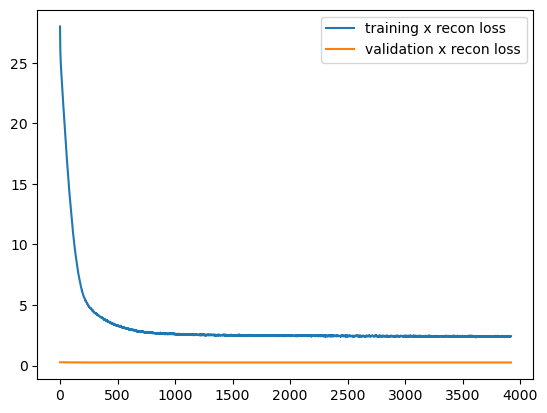

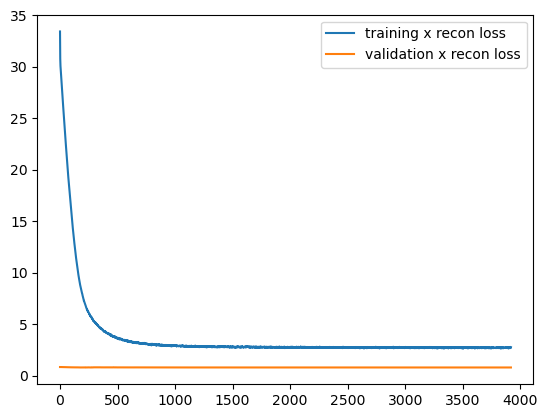

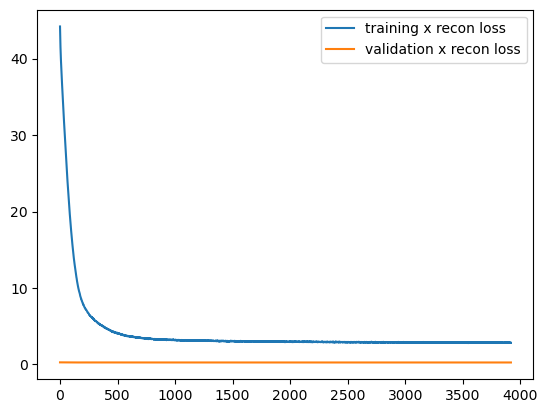

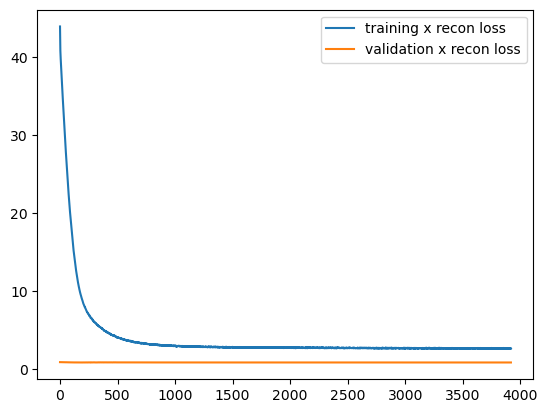

In [10]:
torch.save(model_rna.cpu().state_dict(), os.path.join(modelsavepath,'encode_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_'+str(loadEpoch)+'_ep'+str(ep)+'_rna.pt'))
torch.save(model_atac.cpu().state_dict(), os.path.join(modelsavepath,'encode_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(hiddenSize)+'_'+str(loadEpoch)+'_ep'+str(ep)+'_atac.pt'))


model_rna.cuda()
model_atac.cuda()
with open(os.path.join(logsavepath,'train_loss_encode_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'wb') as output:
    pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_encode_rna_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'wb') as output:
    pickle.dump(train_loss_rna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_encode_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'wb') as output:
    pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_encode_rna_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'wb') as output:
    pickle.dump(val_loss_rna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_encode_atac_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'wb') as output:
    pickle.dump(train_loss_atac, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_encode_atac_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'wb') as output:
    pickle.dump(val_loss_atac, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_encode_rnaShared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'wb') as output:
    pickle.dump(train_loss_rna_shared, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_encode_rnaShared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'wb') as output:
    pickle.dump(val_loss_rna_shared, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_encode_atacShared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'wb') as output:
    pickle.dump(train_loss_atac_shared, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_encode_atacShared_'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'wb') as output:
    pickle.dump(val_loss_atac_shared, output, pickle.HIGHEST_PROTOCOL)


plt.plot(np.arange(epochs),train_loss_rna)
plt.plot(np.arange(epochs),val_loss_rna)
plt.legend(['training x recon loss','validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_encode'+str(sharedSize)+'_'+str(dSpecificSize)+'_rna'+'_'+str(loadEpoch)+'.jpg'))
plt.show()



plt.plot(np.arange(epochs),train_loss_atac)
plt.plot(np.arange(epochs),val_loss_atac)
plt.legend(['training x recon loss','validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_encode'+str(sharedSize)+'_'+str(dSpecificSize)+'_atac'+'_'+str(loadEpoch)+'.jpg'))
plt.show()

plt.plot(np.arange(epochs),train_loss_rna_shared)
plt.plot(np.arange(epochs),val_loss_rna_shared)
plt.legend(['training x recon loss','validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_rnaShared_encode'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)+'.jpg'))
plt.show()



plt.plot(np.arange(epochs),train_loss_atac_shared)
plt.plot(np.arange(epochs),val_loss_atac_shared)
plt.legend(['training x recon loss','validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_atacShared_encode'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)+'.jpg'))
plt.show()



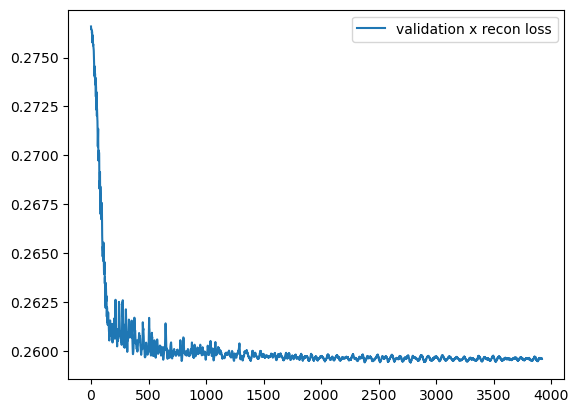

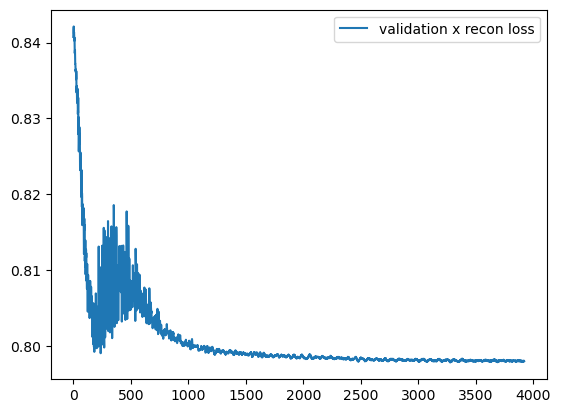

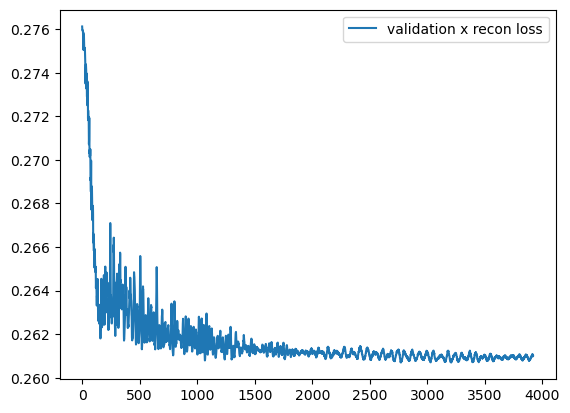

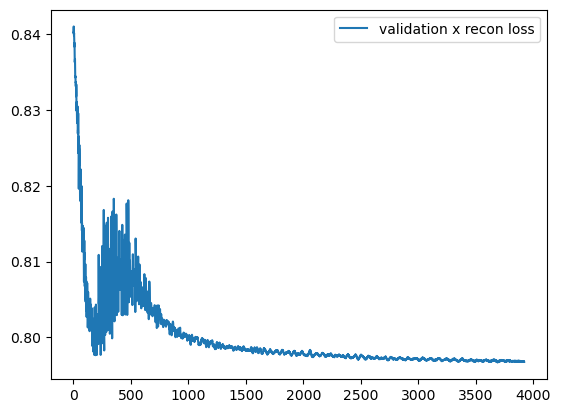

In [11]:
plt.plot(np.arange(epochs),val_loss_rna)
plt.legend(['validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'lossval_seed3_encode'+str(sharedSize)+'_'+str(dSpecificSize)+'_rna'+'_'+str(loadEpoch)+'.jpg'))
plt.show()



plt.plot(np.arange(epochs),val_loss_atac)
plt.legend(['validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'lossval_seed3_encode'+str(sharedSize)+'_'+str(dSpecificSize)+'_atac'+'_'+str(loadEpoch)+'.jpg'))
plt.show()

plt.plot(np.arange(epochs),val_loss_rna_shared)
plt.legend(['validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'lossval_seed3_rnaShared_encode'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)+'.jpg'))
plt.show()



plt.plot(np.arange(epochs),val_loss_atac_shared)
plt.legend(['validation x recon loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'lossval_seed3_atacShared_encode'+str(sharedSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)+'.jpg'))
plt.show()

In [12]:
minEpoch=0
minLoss=np.inf
for ep_i in range(0,ep,saveFreq):
    minLossRNA=min(val_loss_rna[ep_i],val_loss_rna_shared[ep_i])
    minLossATAC=min(val_loss_atac[ep_i],val_loss_atac_shared[ep_i])
    if minLossRNA+minLossATAC<minLoss:
        minLoss=minLossRNA+minLossATAC
        minEpoch=ep_i
print(minEpoch)
print(minLoss)

3900
1.0564160346984863
